## TODO

- I need to correct the token count
- CoT plots:
    - Neue plots wenn nur eine Representation: Am besten alle modelle nebeneinander und dann aber übereinander CoT vs naive? oder difference berechnen und dann ploten +/- 0; Oder einfach wie bei representation und dann Vergleichen 


## Imports

In [1]:
import os
import json
import ast
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output

from itertools import combinations
import matplotlib.pyplot as plt
import holoviews as hv
from adjustText import adjust_text
from tot.methods.arc_utils import load_arc_tasks
import warnings
warnings.filterwarnings("ignore")

/home/jbriem/miniconda3/envs/mixtral/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/jbriem/miniconda3/envs/mixtral/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/jbriem/miniconda3/envs/mixtral/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
SOTA = {
    'arc': {
        'categories_cnt': {'training': 23},
        'success_cnt': 23,
        'categories_rate': {'training': 0.46},
        'success_rate': 0.46
    },
    'arc_h_v': {
        'categories_cnt': {
            'fill_h': 48, 'fill_v': 49, 'move_h': 21, 'move_v': 20, 'pile_h': 42, 'pile_v': 37
        },
        'success_cnt': 217,
        'categories_rate': {
            'fill_h': 0.96, 'fill_v': 0.98, 'move_h': 0.42, 'move_v': 0.4, 'pile_h': 0.84, 'pile_v': 0.74
        },
        'success_rate': 0.7233333333333334
    },
    'arc_1D': {
        'categories_cnt': {
            '1d_denoising_1c': 48, '1d_denoising_mc': 50, '1d_fill': 49, '1d_flip': 50,
            '1d_hollow': 48, '1d_mirror': 13, '1d_move_1p': 50, '1d_move_2p': 50,
            '1d_move_2p_dp': 50, '1d_move_3p': 49, '1d_move_dp': 37, '1d_padded_fill': 44,
            '1d_pcopy_1c': 45, '1d_pcopy_mc': 47, '1d_recolor_cmp': 28, '1d_recolor_cnt': 40,
            '1d_recolor_oe': 13, '1d_scale_dp': 46
        },
        'success_cnt': 757,
        'categories_rate': {
            '1d_denoising_1c': 0.96, '1d_denoising_mc': 1.0, '1d_fill': 0.98, '1d_flip': 1.0,
            '1d_hollow': 0.96, '1d_mirror': 0.26, '1d_move_1p': 1.0, '1d_move_2p': 1.0,
            '1d_move_2p_dp': 1.0, '1d_move_3p': 0.98, '1d_move_dp': 0.74, '1d_padded_fill': 0.88,
            '1d_pcopy_1c': 0.9, '1d_pcopy_mc': 0.94, '1d_recolor_cmp': 0.56, '1d_recolor_cnt': 0.8,
            '1d_recolor_oe': 0.26, '1d_scale_dp': 0.92
        },
        'success_rate': 0.8411111111111111
    }
}



## Helper functions

### Create log summaries

In [3]:
def flatten_dict(d, parent_key='', sep='_'):
    """
    Flatten a nested dictionary. Concatenate keys for nested elements.
    """
    items = []
    for k, v in d.items():
        new_key = f'{parent_key}{sep}{k}' if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        elif k == "new_representation":
            if v is None:
                items.append((new_key, "0 - 9"))
            elif "." in v:
                items.append((new_key, "'.', 'a' - 'i'"))
            elif "a" in v:
                items.append((new_key, "'a' - 'j'"))

            
        else:
            items.append((new_key, v))
    return dict(items)

def get_avg_task_complexity(tasks_jsons, tasks_names, solved_tasks=None):  
    # derive complexity => number of pixels in the test input
    complexity = []
    for task_json in tasks_jsons:
        array = np.array(task_json["test"][0]["input"])
        shape = array.shape
        complexity.append(np.prod(shape))

    df = pd.DataFrame({'task_name': tasks_names, 'complexity': complexity})
    
    if solved_tasks is None:
        return df.complexity.mean()  
       
    sum_complexity = 0
    for solved_task in solved_tasks:
        index = np.where( solved_task[0] == df['task_name'])
        sum_complexity += df['complexity'].iloc[index[0][0]]
    if sum_complexity == 0:
        return 0
    return sum_complexity / len(solved_tasks)
    
def read_and_parse_tasks_log(path, save_to_csv=False):
    data = []

    if not os.path.isdir(path):
        print(f"The provided path {path} is not a directory.")
        return pd.DataFrame()
    
    # derive task
    task = path.split("/")[-1]
    # get all tasks
    if task == "arc":
        data_dir = "ARC_datasets/ARC"
    elif task == "arc_1D":
        data_dir = "ARC_datasets/1D-ARC/dataset"
    elif task == "arc_h_v":
        data_dir = "ARC_datasets/arc_new"
    #data_dir = os.path.join("tree-of-thought-llm/src/tot/data", task)
    tasks_jsons, tasks_names, _ = load_arc_tasks(data_dir, task)

    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            log_file = os.path.join(item_path, 'all_tasks_log.json')
            if os.path.isfile(log_file):
                try:
                    with open(log_file, 'r') as file:
                        log_data = json.load(file)[0]  # Read only the first item
                        flattened_data = flatten_dict(log_data)
                        solved_tasks = flattened_data["solved_tasks"]
                        if len(solved_tasks) >= 3:
                            avg_complexity = get_avg_task_complexity(tasks_jsons, tasks_names, flattened_data["solved_tasks"])
                        else:
                            avg_complexity = 0 
                        flattened_data["avg_complexity"] = avg_complexity
                        if "solved_tasks_str_comparison" not in flattened_data:
                            flattened_data["success_cnt_w/o_str_comparison"] = 0
                            flattened_data["success_rate_w/o_str_comparison"] = 0
                        else:
                            flattened_data["success_cnt_w/o_str_comparison"] = flattened_data["success_cnt"] - len(flattened_data["solved_tasks_str_comparison"])
                            if flattened_data["success_cnt"] == 0:
                                flattened_data["success_rate_w/o_str_comparison"] = 0
                            else:
                                flattened_data["success_rate_w/o_str_comparison"] = flattened_data["success_cnt_w/o_str_comparison"] / (flattened_data["success_cnt"] / flattened_data["success_rate"])
                        data.append(flattened_data)
                except Exception as e:
                    print(f"Error reading {log_file}: {e}")
    df = pd.DataFrame(data)
    if save_to_csv:
        df.to_csv(path+"/summary.csv", index=False)
        print("saved to "+path+"/summary.csv")
    return df


In [9]:
path = "results/baseline_cot/arc"
data = read_and_parse_tasks_log(path, save_to_csv=True)
#display(data)

Total number of tasks: 800
saved to results/baseline_cot/arc/summary.csv


### Plotting functions

In [3]:
def plot_model_performance_across_runs(dataframe, exp_column, score_column, run_column="model", task="", top_n_models=None, SOTA=None, value_ticks="highest_only", small_fig=False):
    def plot_single_dataframe(df, ax, run_column, exp_column, score_column, task="", top_n_models=None, SOTA=None, value_ticks="highest_only", small_fig=False):
        # Filter the relevant columns
        df_filtered = df[[run_column, exp_column, score_column]]

        # Convert Score to numeric values if they are in percentage format
        if df_filtered[score_column].dtype == object:
            df_filtered[score_column] = df_filtered[score_column].str.rstrip('%').astype('float') / 100.0

        # Group by run_column and find the maximum 'Success' value for each group
        group_max = df_filtered.groupby(run_column)[score_column].max()

        # Sort the groups by maximum 'Success' value
        sorted_groups = group_max.sort_values(ascending=False).index.tolist()

        # filter the top n models
        if top_n_models is not None:
            sorted_groups = sorted_groups[:top_n_models]

        # Sort within each group by 'Representation' and concatenate
        if exp_column == "new_representation":
            sorted_df = pd.concat([df_filtered[df_filtered[run_column] == group].sort_values(by=exp_column) for group in sorted_groups])
            sorted_df.reset_index(drop=True, inplace=True)
            keys = list(sorted_df["new_representation"].unique())
            keys.sort()
        else:
            keys = []
            sorted_df = df_filtered.copy()
        

        # Handling for score column not in percentage format
        if score_column == "avg_complexity":
            m = 1
        else:
            m = 1

        # Create a line plot for each model using ax object
        for i, model in enumerate(sorted_groups):
            model_data = sorted_df[sorted_df[run_column] == model]
            rows_to_add = []
            for key in keys:
                if not model_data[model_data[exp_column] == key].empty:
                    continue  # Skip to next key if this one already exists
                else:
                    # If the key does not exist, create a new row
                    new_row = model_data.iloc[0].copy()  # Copy any row, here we copy the first row
                    new_row[exp_column] = key  # Set the 'A' column to the missing value
                    new_row[score_column] = 0  # Set the 'success_rate' to 0
                    rows_to_add.append(new_row)
            if rows_to_add:
                new_rows_df = pd.DataFrame(rows_to_add)
                model_data = pd.concat([model_data, new_rows_df])  # Append the new row to the DataFrame
                model_data = model_data.sort_values(by=exp_column)
            
            line = ax.plot(model_data[exp_column], model_data[score_column] * m, marker='o', label=model.split("/")[-1])
            line_color = line[0].get_color()  # Get the color of the line

            # Highlight highest score for the model
            max_score = model_data[score_column].max()
            max_score_data = model_data[model_data[score_column] == max_score]
            ax.scatter(max_score_data[exp_column], max_score_data[score_column] * m, color=line_color, s=60, edgecolor='black', zorder=5)
            if value_ticks == "highest_only":
                for _, row in max_score_data.iterrows():
                    ax.annotate(f"{row[score_column]*m:.2f}", (row[exp_column], row[score_column]*m), textcoords="offset points", xytext=(0,5), ha='center')
            elif value_ticks == "all":
                # annotate all scores
                for _, row in model_data.iterrows():
                    if i == 0:
                        add = 0
                    elif i == 1:
                        add = 2
                    elif i == 2:
                        add = -4
                    elif i == 3:
                        add = -13
                    elif i == 4:
                        add = -16
                    else: 
                        add = 0
                    # if row[exp_column] == "Naive":
                    #     ax.annotate(f"{row[score_column]*m:.2f}", (row[exp_column], row[score_column]*m), textcoords="offset points", xytext=(-15,5+add), ha='center')
                    # else:
                    #     ax.annotate(f"{row[score_column]*m:.2f}", (row[exp_column], row[score_column]*m), textcoords="offset points", xytext=(13,5+add), ha='center')

            
        # Add SOTA and other lines if applicable, using ax.axhline()
        if SOTA is not None and task in SOTA:
            success_rate = SOTA[task]["success_rate"] * m
            ax.axhline(y=success_rate, color='r', linestyle=':', label='SOTA')

        # Adjust the x-axis limits slightly to provide padding
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(xmin - 0.5, xmax + 0.5)

        # Add legend, labels, and title using ax methods
        ax.set_xlabel(exp_column)
        ax.set_ylabel(score_column)
        if task == "arc_1D":
            task_name = "1D-ARC -"
        elif task == "arc_h_v":
            task_name = "ARC variant: object orientation -" 
        elif task == "arc":
            task_name = "ARC Subset -"
        else:
            task_name = ""
        
        if small_fig and task_name != "":
            task_name += "\n"
        else:
            task_name += " "
        
        if score_column == "avg_complexity":
            plt.ylabel('Average Complexity [# of Pixels in test input]')
            ax.set_title(task_name + 'Complexity of Solved Tasks')#  of Models Across Different Pixel Grid Representations')

        else:
            plt.ylabel('Success Rate')
            ax.set_title(task_name + 'Task Performance')#  of Models Across Different Pixel Grid Representations')

        if exp_column == "new_representation":
            plt.xlabel('Pixel Grid Representations')
            if run_column == "dataset":
                title = "Dataset"
            else:
                title = "Model"
            if top_n_models is not None:
                legend = plt.legend(title=title, loc='upper left', bbox_to_anchor=(1, 0.75))
            else:
                legend = plt.legend(title=title, loc='upper left', bbox_to_anchor=(1, 1.05))
        elif exp_column == "run":
            plt.xlabel('Prompting Strategies')
            if small_fig:
                legend = plt.legend(title="Model", loc='upper center', bbox_to_anchor=(0.45, -0.15), ncol=1)
            else:
                legend = plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1.05))

    # Check if the input is a list of dataframes
    if isinstance(dataframe, list):
        # Determine the number of rows needed for subplots based on the number of dataframes
        ncols = len(dataframe)
        fig, axs = plt.subplots(ncols=ncols, figsize=(10*ncols,   6))
        
        if ncols > 1:
            for i, df in enumerate(dataframe):
                # Set the current axis to the subplot axis
                ax = axs[i]
                # Generate a subplot title based on the dataframe index or any other criteria
                subplot_title = f"Experiment {i+1}"
                plot_single_dataframe(df, ax, run_column, exp_column, score_column, task, top_n_models, SOTA, value_ticks, small_fig)
    else:
        # If not a list, just plot the original dataframe
        if small_fig:
            fig, ax = plt.subplots(figsize=(4, 6))
        else:
            fig, ax = plt.subplots()
        plot_single_dataframe(dataframe, ax, run_column, exp_column, score_column, task, top_n_models, SOTA, value_ticks, small_fig)

    # Set the style for the plots
    plt.style.use('seaborn-darkgrid')  # This applies globally, so it's okay to keep as plt.
    sns.set_palette("viridis")  # This also applies globally.

    plt.tight_layout()
    plt.show()

# Example of how you'd call the function:
# plot_model_performance_across_runs([df1, df2, df3], 'Experiment', 'Success Rate')


In [4]:
# def plot_model_performance_across_runs(dataframe, exp_column, score_column, run_column="model", task="", top_n_models=None, SOTA=None):
#     # Filter the relevant columns
#     df_filtered = dataframe[[run_column, exp_column, score_column]]

#     # Convert Score to numeric values if they are in percentage format
#     if df_filtered[score_column].dtype == object:
#         df_filtered[score_column] = df_filtered[score_column].str.rstrip('%').astype('float') / 100.0

#     # Group by run_column and find the maximum 'Success' value for each group
#     group_max = df_filtered.groupby(run_column)[score_column].max()

#     # Sort the groups by maximum 'Success' value
#     sorted_groups = group_max.sort_values(ascending=False).index.tolist()

#     # filter the top n models
#     if top_n_models is not None:
#         sorted_groups = sorted_groups[:top_n_models]


#     # Sort within each group by 'Representation' and concatenate
#     if exp_column == "new_representation":
#         sorted_df = pd.concat([df_filtered[df_filtered[run_column] == group].sort_values(by=exp_column) for group in sorted_groups])
#         sorted_df.reset_index(drop=True, inplace=True)
#     else:
#         sorted_df = df_filtered.copy()
    
#     # Set the style for the plots
#     plt.style.use('seaborn-darkgrid')
#     sns.set_palette("viridis")
    
#     # add multiplication if not in percentage format
#     if score_column == "avg_complexity":
#         m = 100
#     else: 
#         m = 1
        
#     # Create a line plot for each model
#     tmp_last_y_left = tmp_last_y_right = -999
#     for model in sorted_groups:
#         model_data = sorted_df[sorted_df[run_column] == model]
#         line = plt.plot(model_data[exp_column], model_data[score_column], marker='o', label=model.split("/")[-1])
#         line_color = line[0].get_color()  # Get the color of the line
        
#         # Find the highest score for the model
#         max_score = model_data[score_column].max()
#         max_score_data = model_data[model_data[score_column] == max_score]
        
#         if max_score == 0:
#             continue

#         # Highlight the highest score for the model
#         plt.scatter(max_score_data[exp_column], max_score_data[score_column], color=line_color, s=60, edgecolor='black', zorder=5)
        
#         # Check the position of the highest score and adjust the annotation accordingly
#         for _, row in max_score_data.iterrows():
#             data_point_y = row[score_column]
#             if row[exp_column] == model_data[exp_column].iloc[0]:  # If highest score is in the first run
#                 if data_point_y - tmp_last_y_left < 0.02*m and data_point_y - tmp_last_y_left > -0.02*m:
#                     y_annotation_lift_l += -4
#                 else:
#                     y_annotation_lift_l = 0
#                 plt.annotate(f"{row[score_column]:.2f}", (row[exp_column], row[score_column]),
#                             textcoords="offset points", xytext=(-35,2+y_annotation_lift_l), ha='left')
#                 tmp_last_y_left = data_point_y
#             elif row[exp_column] == model_data[exp_column].iloc[-1]:  # If highest score is in the last run
#                 if data_point_y - tmp_last_y_right < 0.02*m and data_point_y - tmp_last_y_right > -0.02*m:
#                     y_annotation_lift_r += -4
#                 else:
#                     y_annotation_lift_r = 0
#                 plt.annotate(f"{row[score_column]:.2f}", (row[exp_column], row[score_column]),
#                             textcoords="offset points", xytext=(35,2+y_annotation_lift_r), ha='right')
#                 tmp_last_y_right = data_point_y
#             else:  # For all other cases, put the annotation above the point
#                 plt.annotate(f"{row[score_column]:.2f}", (row[exp_column], row[score_column]),
#                             textcoords="offset points", xytext=(0,7), ha='center')

#     # add SOTA
#     if SOTA is not None:
#         success_rate = SOTA[task]["success_rate"]
#         plt.axhline(y=success_rate, color='r', linestyle=':', label='SOTA')
     
#     # add avg complexity of whole task
#     if score_column == "avg_complexity":
#         # get all tasks
#         data_dir = os.path.join("tree-of-thought-llm/src/tot/data", task)
#         tasks_jsons, tasks_names, _ = load_arc_tasks(data_dir, task)
#         avg_complexity = get_avg_task_complexity(tasks_jsons, tasks_names)
#         plt.axhline(y=avg_complexity, color='r', linestyle=':', label='Average over all tasks')
        
#     # Adjust margins here by setting x-axis limits
#     # Get current axis
#     ax = plt.gca()
#     # Retrieve the current limits
#     xmin, xmax = ax.get_xlim()
#     # Set new limits with some padding
#     ax.set_xlim(xmin - 0.5, xmax + 0.5)
        
#     # Adding legends, labels and title
#     plt.legend(title=run_column, loc='upper left', bbox_to_anchor=(1, 1))
#     plt.xlabel(exp_column)
#     plt.ylabel(score_column)
#     if task == "arc_1D":
#         task_name = "1D ARC - "
#     elif task == "arc_h_v":
#         task_name = "ARC horizontal vs. vertical - " 
#     elif task == "arc":
#         task_name = "50 ARC Tasks - "
#     else:
#         task_name = ""
    
#     if score_column == "avg_complexity":
#         plt.title(task_name + 'Average Complexity of Models Across different Experiments')
#     elif score_column == "success_rate":
#         plt.title(task_name + 'Success rate of Models Across different Experiments')
#     else:
#         plt.title(task_name + 'Performance of Models Across different Experiments')

#     # Show the plot
#     plt.show()


In [4]:
def plot_grouped_bar_chart(dataframe, group_by="model", group_col="success_cat", top_n_models=3, asc=True, SOTA=None, highlight_pretrained_models=False):
    # filter on top n models
    if top_n_models is not None:
        # dataframe = dataframe.sort_values(by='success_rate', ascending=False)
        if "success_rate_w/o_str_comparison" in dataframe.columns:
            # dataframe = dataframe.sort_values(by="success_rate_w/o_str_comparison", ascending=False)
            dataframe = dataframe.sort_values(by="success_rate", ascending=False)
        elif group_by == "new_representation":
            pass
        else:
            dataframe = dataframe.sort_values(by='success_rate', ascending=False)
        dataframe = dataframe[:top_n_models]
    if group_by == "new_representation":
        pass
    else:
        if asc:
            dataframe = dataframe.sort_values(by='success_rate', ascending=True)
        else:
            dataframe = dataframe.sort_values(by='success_rate', ascending=False)
        
    if group_col ==  "success_cat":
        # Filter columns that start with 'cat_success_'
        success_columns = [col for col in dataframe.columns if col.startswith('cat_success_rate_')]
    elif group_col == "str_cmp":
        success_columns = ["success_rate", "success_rate_w/o_str_comparison"]
    elif group_col == "dataset":
        success_columns = [col for col in dataframe.columns if col.startswith('success_rate_')]
    # filter dataframe
    if "model" in dataframe.columns:
        dataframe = dataframe[['model'] + success_columns]
    elif group_by == "new_representation":
        dataframe = dataframe[['new_representation'] + success_columns]
    else:
        dataframe = dataframe[success_columns]
    # delete model prefix
    if "model" in dataframe.columns:
        dataframe["model"] = [m.split("/")[-1] for m in dataframe["model"]]
    
    # add SOTA
    if SOTA is not None:
        modified_keys_dict = {'cat_success_rate_' + key: value for key, value in SOTA["categories_rate"].items()}
        new_row = pd.DataFrame([modified_keys_dict])
        new_row['model'] = 'SOTA'
        dataframe = pd.concat([dataframe, new_row], ignore_index=True)
    
    if group_by == "model":
        models = dataframe[group_by].unique()
    elif group_by == ["success_rate", "success_rate_w/o_str_comparison"]:
        models = ["success_rate", "success_rate_w/o_str_comparison"]
        labels = ["Substring comparison", "JSON value comparison"]
    elif group_by == "new_representation":
        models = dataframe[group_by].unique()
        
    n_models = len(models)
    
    # Number of groups
    if group_by == "model":
        n_groups = len(success_columns)
    elif group_by == ["success_rate", "success_rate_w/o_str_comparison"]:
        n_groups = len(dataframe)
    elif group_by == "new_representation":
        n_groups = len(success_columns)
    # Set the style for the plots
    plt.style.use('seaborn-darkgrid')  
    sns.set_palette("viridis")    
    # Create figure and axis
    fig, ax = plt.subplots()
    # plt.axhline(y=1, color='r', linestyle=':', label='100%')
    # Set the positions and width for the bars
    index = np.arange(n_groups)
    bar_width = 1/(n_models+1)
    #spacing = bar_width * 0.1  # Adjust this value to increase or decrease space
    opacity = 0.8
    
    # Generate a bar for each model in each group
    for i, model in enumerate(models):
        # Select data for the model
        if group_by == "model":
            model_data = dataframe[dataframe[group_by] == model][success_columns].iloc[0]
        elif group_by == ["success_rate", "success_rate_w/o_str_comparison"]:
            model_data = dataframe[group_by[i]]
        elif group_by == "new_representation":
            model_data = dataframe[dataframe[group_by] == model][success_columns].iloc[0]
        # Position of the model's bar in each group
        pos = [-bar_width+ p + bar_width * i for p in index]
        
        # Plotting
        if group_col == "str_cmp":
            plt.bar(pos, model_data, bar_width, alpha=opacity, label=labels[i])
        else:
            plt.bar(pos, model_data, bar_width, alpha=opacity, label=model)
    
    # Adding features to the plot
    plt.ylabel('Success Rate')

    if group_col == "success_cat":
        plt.xlabel('Categories')
        plt.title('Success rate by model and category')
        plt.xticks(index + bar_width / 2, [s.replace("cat_success_rate_", "") for s in success_columns], rotation=35, ha="right")
        legend = plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 0.7))
    if group_col == "str_cmp":
        plt.xlabel('Models')
        plt.title('Success rate comparison based on task checking method on 1D-ARC')
        plt.xticks(index + bar_width / 2, [m for m in dataframe["model"]], rotation=35, ha="right")
        legend = plt.legend(title="Task checking method", loc='upper left', bbox_to_anchor=(1, 0.7))
    if group_col == "dataset":
        plt.xlabel('Dataset')
        plt.title('Average success rate of all models across 3 pixel representations')
        plt.xticks(index + bar_width / 2, [m.split("success_rate_")[-1] for m in success_columns], rotation=35, ha="right")
        legend = plt.legend(title="Pixel representations", loc='upper left', bbox_to_anchor=(1, 0.7))        
    
    if highlight_pretrained_models:
        # Highlighting specific x-axis ticks
        tick_labels = ax.get_xticklabels()  # Get the current tick labels on the x-axis
        for label in tick_labels:
            text = label.get_text()  # Get the text of the tick label
            # Check if 'chat' or 'instruct' is in the tick label text
            if 'chat' not in text.lower() and 'instruct' not in text.lower() and "gpt-" not in text.lower() and "platypus" not in text.lower():
                # label.set_color('red')  # Change the color to red
                label.set_fontweight('bold')  # Make the label bold
            
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [5]:
# For Venn diagramm

def get_overlapping_tasks(data):

    data["solved_tasks"] = [[task[0] for task in tasks] for tasks in data["solved_tasks"]]

    # Create a dictionary to store solved tasks for each model
    model_tasks = {row['model']: set(row['solved_tasks']) for _, row in data.iterrows()}

    result = {}

    # Create combinations of models and find the overlapping tasks for triples
    combinations_triples = list(combinations(data['model'], 3))

    for combination in combinations_triples:
        model1, model2, model3 = combination
        overlapping_tasks = model_tasks[model1].intersection(model_tasks[model2], model_tasks[model3])
        result[f'{model1}-{model2}-{model3}'] = list(overlapping_tasks)

        # Remove overlapping tasks from individual models
        for model in combination:
            model_tasks[model] -= overlapping_tasks

    # Create combinations of models and find the overlapping tasks for pairs
    combinations_pairs = list(combinations(data['model'], 2))

    for combination in combinations_pairs:
        model1, model2 = combination
        overlapping_tasks = model_tasks[model1].intersection(model_tasks[model2])
        result[f'{model1}-{model2}'] = list(overlapping_tasks)

        # Remove overlapping tasks from individual models
        for model in combination:
            model_tasks[model] -= overlapping_tasks

    # For individual models
    for model, tasks in model_tasks.items():
        result[model] = list(tasks)

    return result



In [ ]:
# Group the DataFrame by the "Model" column and find the index of the maximum "Success_rate" within each group
idx = data.groupby('model')['success_rate'].idxmax()
# Extract the rows corresponding to the best "Success_rate" for each model
best_rows = data.loc[idx]
# Sort the best_rows DataFrame by "Success_rate" in descending order
best_rows_sorted = best_rows.sort_values(by='success_rate', ascending=False)
# Select the top 4 rows (i.e., the 4 best models)
top_3_models = best_rows_sorted.head(3)
top_3_models["solved_tasks"]
# Call the function with your DataFrame
result = get_overlapping_tasks(top_3_models)

#Print the result
for model, tasks in result.items():
    print(f'{model}: {len(tasks)}')

In [ ]:
top_3_models["success_cnt"]

### Task analysis

In [5]:
def analyze_random_tasks(data, task, exp, n_models, n_tasks, only_unsolved=False, only_solved=False, starting_index=0, only_save_as_txt=False):
    # random seed
    np.random.seed(42)
    # get all tasks
    data_dir = os.path.join("tree-of-thought-llm/src/tot/data", task)
    _, tasks_names, _ = load_arc_tasks(data_dir, task)
    # get experiment data of top n models
    top_n_runs = data.sort_values(by='success_rate_w/o_str_comparison', ascending=False)[:n_models]
    # iterate over the top n runs
    selected_tasks = {}
    for index, row in top_n_runs.iterrows():
        #print(row["solved_tasks"])
        solved_tasks = ast.literal_eval(row["solved_tasks"])
        solved_tasks = [t[0] for t in solved_tasks]
        unsolved_tasks = [t for t in tasks_names if t not in solved_tasks]
        if only_unsolved:
            solved_or_unsolved = "unsolved"
            tasks = unsolved_tasks
        elif only_solved:
            solved_or_unsolved = "solved"
            tasks = solved_tasks
        else:
            solved_or_unsolved = "all"
            tasks = tasks_names
        np.random.shuffle(tasks)
        if n_tasks > len(tasks):
            n_tasks = len(tasks)
        if exp == "baseline_cot":
            run_postfix = "naive_cot"
        selected_tasks[f'{row["model"].split("/")[-1]}_{run_postfix}_{row["date"]}'] = np.random.choice(tasks, n_tasks, replace=False)

    txt = ""
    for run, tasks in selected_tasks.items():
        results_path = f"results/{exp}/{task}/{run}/tasks/"
        
        run_txt = '''
############################################################################################################
New Run: {}
############################################################################################################
'''.format(run)
        print(run_txt)
        if only_save_as_txt:
            txt += run_txt+"\n"
        user_input = input("Do you want to continue? (y/n) Or skip to next model? (skip)")
        if user_input == "skip":
            continue
        elif user_input != "y":
            print("Aborted")
            break
        
        for i, t in enumerate(tasks):
            if i < starting_index:
                continue
            task_path = os.path.join(results_path, t[:-5]+"_LLM_answer.txt")
            with open(task_path) as f:
                content = f.read()
            if only_save_as_txt:
                txt += f'''\n############################################################################################################\nTask: {t}\n\n{content}\n\n'''
            else:
                print(t)
                print(content)
                user_input = input("Do you want to continue? (y/n) Or show again? (again)")
                while user_input == "again":
                    clear_output() 
                    print(t)
                    print(content)
                    user_input = input("Do you want to continue? (y/n) Or show again? (again)")
                if user_input != "y":
                    clear_output() 
                    print("Aborted")
                    break
                clear_output()
    if only_save_as_txt:
        with open(f"results/baseline_cot/{task}/manual_task_analysis_raw_outputs_{solved_or_unsolved}.txt", "w") as text_file:
            text_file.write(txt)
        print(f"saved to results/{exp}/{task}/manual_task_analysis_raw_outputs_{solved_or_unsolved}.txt")

def get_sankey_source_data(df):
    n_tasks = len(df)
    sankey_edges = pd.DataFrame(columns=['source', 'target', 'value'])
    sankey_edges['source'] = ["tasks"]*2+["description correct"]*2+["description wrong"]*2+["pattern correct"]*2+["pattern wrong"]*2+["instructions correct"]*3+["instructions wrong"]*3
    sankey_edges['target'] = ["description correct", "description wrong"] + ["pattern correct", "pattern wrong"]*2 + ["instructions correct", "instructions wrong"]*2 + ["output correct", "output wrong","output error"]*2 

    sankey_edges["value"].iloc[0] = df['description_of_difference_correct_and_complete'].sum() / n_tasks
    sankey_edges["value"].iloc[1] = 1 - df['description_of_difference_correct_and_complete'].sum() / n_tasks

    # source description
    sankey_edges["value"].iloc[2] = df[
        (df['description_of_difference_correct_and_complete'] == 1) 
        & (df['pattern_correct'] == 1)
        & (df['conditions_correct'] == 1)].shape[0] / n_tasks
    sankey_edges["value"].iloc[3] = df[
        (df['description_of_difference_correct_and_complete'] == 1) 
        & ((df['pattern_correct'] == 0) | (df['conditions_correct'] == 0))].shape[0] / n_tasks
    sankey_edges["value"].iloc[4] = df[
        (df['description_of_difference_correct_and_complete'] == 0) 
        & (df['pattern_correct'] == 1)
        & (df['conditions_correct'] == 1)].shape[0] / n_tasks
    sankey_edges["value"].iloc[5] = df[
        (df['description_of_difference_correct_and_complete'] == 0) 
        & ((df['pattern_correct'] == 0) | (df['conditions_correct'] == 0))].shape[0] / n_tasks

    # source pattern 
    sankey_edges["value"].iloc[6] = df[
        (df['pattern_correct'] == 1)
        & (df['conditions_correct'] == 1)
        & (df['instructions_correct'] == 1)].shape[0] / n_tasks
    sankey_edges["value"].iloc[7] = df[
        (df['pattern_correct'] == 1)
        & (df['conditions_correct'] == 1)
        & (df['instructions_correct'] == 0)].shape[0] / n_tasks
    sankey_edges["value"].iloc[8] = df[
        ((df['pattern_correct'] == 0) | (df['conditions_correct'] == 0))
        & (df['instructions_correct'] == 1)].shape[0] / n_tasks
    sankey_edges["value"].iloc[9] = df[
        ((df['pattern_correct'] == 0) | (df['conditions_correct'] == 0))
        & (df['instructions_correct'] == 0)].shape[0] / n_tasks

    # source instructions 
    sankey_edges["value"].iloc[10] = df[
        (df['instructions_correct'] == 1)
        & (df['test_transformation_correct'] == 1)].shape[0] / n_tasks
    sankey_edges["value"].iloc[11] = df[
        (df['instructions_correct'] == 1)
        & (df['test_transformation_correct'] == 0)].shape[0] / n_tasks
    sankey_edges["value"].iloc[12] = df[
        (df['instructions_correct'] == 1)
        & (df['test_transformation_correct'].isna())].shape[0] / n_tasks
    sankey_edges["value"].iloc[13] = df[
        (df['instructions_correct'] == 0)
        & (df['test_transformation_correct'] == 1)].shape[0] / n_tasks
    sankey_edges["value"].iloc[14] = df[
        (df['instructions_correct'] == 0)
        & (df['test_transformation_correct'] == 0)].shape[0] / n_tasks
    sankey_edges["value"].iloc[15] = df[
        (df['instructions_correct'] == 0)
        & (df['test_transformation_correct'].isna())].shape[0] / n_tasks
    
    sankey_edges["value"] = sankey_edges["value"]*100
    sankey_edges = sankey_edges[sankey_edges["value"] > 0]
    return sankey_edges    
            
def get_task_analysis_kpi(path):
    def calc_metrics(p, df):
        n_tasks = len(df)
        
        # Calculate fraction of tasks where the description of differences between input and output is correct and complete
        description_correct_and_complete_fraction_of_n_tasks = df['description_of_difference_correct_and_complete'].sum() / n_tasks

        # Calculate fraction of tasks where the description of differences between input and output is correct but incomplete
        description_correct_but_missing_relevant_details_fraction_of_n_tasks = df['description_correct_but_missing_relevant_details'].sum() / n_tasks

        # Calculate fraction of tasks where the description of differences between input and output is completely wrong
        description_wrong_fraction_of_n_tasks = 1 - ((df['description_of_difference_correct_and_complete'].sum()+df['description_correct_but_missing_relevant_details'].sum()) / n_tasks)
       
        
        # calculate fraction of examples where the description error is due to bad object detection
        description_error_bc_bad_object_detection_fraction_of_incorrect_descriptions = df['description_error_bc_bad_object_detection'].sum() / (df['description_of_difference_correct_and_complete'] == 0).sum()

        if "baseline_cot/arc_1D" in p:
            # Calculate fraction of correct test case descriptions
            test_case_description_correct_fraction_of_n_tasks = df['test_description_correct'].sum() / n_tasks
            
            # calculate fraction of examples where the test case description error is due to bad object detection
            test_case_description_error_bc_bad_object_detection_fraction_of_all_where_objects_described_in_detail = (df['test_objects_correct'] == 0).sum() / df['test_object_described_w_all_details'].sum()
            
            # Calculate fraction of correct chain
            correct_chain_fraction_of_n_tasks = df[(df['description_of_difference_correct_and_complete'] == 1) & 
                                        (df['pattern_correct'] == 1) & 
                                        (df['conditions_correct'] == 1) & 
                                        (df['instructions_correct'] == 1) & 
                                        (df['test_transformation_correct'] == 1)].shape[0] / n_tasks
        
        elif "baseline_cot/" in p:
            # Calculate fraction of correct test case descriptions
            test_case_description_correct_fraction_of_n_tasks = df['test_description_correct_and_complete'].sum() / n_tasks
            
            # calculate fraction of examples where the test case description error is due to bad object detection
            test_case_description_error_bc_bad_object_detection_fraction_of_all_where_objects_described_in_detail = df['test_description_error_bc_bad_object_detection'].sum() / (df['test_description_correct_and_complete'] == 0).sum()
            
        # Calculate fraction of correct chain
        correct_chain_fraction_of_n_tasks = df[(df['description_of_difference_correct_and_complete'] == 1) & 
                                    (df['pattern_correct'] == 1) & 
                                    (df['conditions_correct'] == 1) & 
                                    (df['instructions_correct'] == 1) & 
                                    (df['test_transformation_correct'] == 1)].shape[0] / n_tasks
            
        # Calculate fraction of correct pattern
        correct_pattern_and_condition_fraction_of_n_tasks = df[(df['pattern_correct'] == 1) & 
                                      (df['conditions_correct'] == 1)].shape[0] / n_tasks
        
        # Calculate fraction of correct instructions
        correct_instructions_fraction_of_n_tasks = df['instructions_correct'].sum() / n_tasks
        
        # Calculate fraction of correct transformations
        correct_transformations_fraction_of_n_tasks = df['test_transformation_correct'].sum() / n_tasks
        
        # Calculate fraction of instructions that are correct with respect to wrong pattern
        instructions_fit_wrong_pattern_fraction_of_wrong_pattern = df[(df['pattern_correct'] == 0) & 
                                                     (df['wrong_instructions_but_fit_to_pattern'] == 1)].shape[0] / (df['pattern_correct'] == 0).sum()
        
        # calculate fraction of transformations that are correct with respect to wrong pattern
        transformations_fit_wrong_pattern_fraction_of_wrong_pattern = df[(df['pattern_correct'] == 0) & 
                                                       (df['wrong_test_transformation_but_fit_to_pattern'] == 1)].shape[0] / (df['pattern_correct'] == 0).sum()
        
        # calculate fraction of correct key concept of n tasks
        key_concept_correct_fraction_of_n_tasks = df['key_concept_correct'].sum() / n_tasks
        
        # calculate fraction of wrong pattern but identified key concept correctly
        wrong_pattern_but_correct_key_concept_fraction_of_wrong_pattern = df[(df['pattern_correct'] == 0) & 
                                                    (df['key_concept_correct'] == 1)].shape[0] / (df['pattern_correct'] == 0).sum()
        
        # calculate fraction of tasks where numbers were interpreted arithmetically
        arithmetic_interpretation_fraction_of_n_tasks = df['numbers_interpreted_arithmetical'].sum() / n_tasks
    
        return {
            "n_tasks": n_tasks,
            "description_correct_and_complete_fraction_of_n_tasks": description_correct_and_complete_fraction_of_n_tasks,
            "description_correct_but_missing_relevant_details_fraction_of_n_tasks": description_correct_but_missing_relevant_details_fraction_of_n_tasks,
            "description_wrong_fraction_of_n_tasks": description_wrong_fraction_of_n_tasks,
            "description_error_bc_bad_object_detection_fraction_of_incorrect_descriptions": description_error_bc_bad_object_detection_fraction_of_incorrect_descriptions,
            "test_case_description_correct_fraction_of_n_tasks": test_case_description_correct_fraction_of_n_tasks,
            "test_case_description_error_bc_bad_object_detection_fraction_of_all_where_objects_described_in_detail": test_case_description_error_bc_bad_object_detection_fraction_of_all_where_objects_described_in_detail,
            "correct_chain_fraction_of_n_tasks": correct_chain_fraction_of_n_tasks,
            "correct_pattern_and_condition_fraction_of_n_tasks": correct_pattern_and_condition_fraction_of_n_tasks,
            "correct_instructions_fraction_of_n_tasks": correct_instructions_fraction_of_n_tasks,
            "correct_transformations_fraction_of_n_tasks": correct_transformations_fraction_of_n_tasks,
            "instructions_fit_wrong_pattern_fraction_of_wrong_pattern": instructions_fit_wrong_pattern_fraction_of_wrong_pattern,
            "transformations_fit_wrong_pattern_fraction_of_wrong_pattern": transformations_fit_wrong_pattern_fraction_of_wrong_pattern,
            "key_concept_correct_fraction_of_n_tasks": key_concept_correct_fraction_of_n_tasks,
            "wrong_pattern_but_correct_key_concept_fraction_of_wrong_pattern": wrong_pattern_but_correct_key_concept_fraction_of_wrong_pattern,
            "arithmetic_interpretation_fraction_of_n_tasks": arithmetic_interpretation_fraction_of_n_tasks
        }
    
    # Open the Excel file and get sheet names
    xls = pd.ExcelFile(path)
    sheet_names = xls.sheet_names
    sheet_names.remove("template")
    sheet_names.remove("Legend")
    
    kpis = {}
    
    df_unsolved = pd.DataFrame()
    df_solved = pd.DataFrame()
    
    for sheet in sheet_names:
        # Load the sheet and remove rows with NaN in the "task_name" column
        df = pd.read_excel(path, sheet_name=sheet)
        df = df.dropna(subset=['task_name'])
        # just take ten in case I have more in the begining
        df = df[:10]
        # Store KPIs for the current sheet
        kpis[sheet] = calc_metrics(path, df)
        
        if "unsolved" in sheet:
            df_unsolved = pd.concat([df_unsolved, df])
        else:
            df_solved = pd.concat([df_solved, df])        
        
    # Store KPIs for the all unsolved
    kpis["all_unsolved"] = calc_metrics(path, df_unsolved)
    # Store KPIs for the all solved
    kpis["all_solved"] = calc_metrics(path, df_solved)
    

    
    return kpis, df_unsolved, df_solved


# Experiments

## Baseline - Naive

### 1D ARC

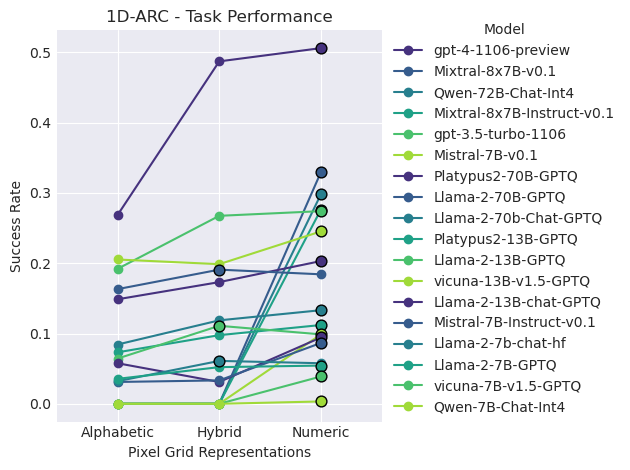

In [214]:
df = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
df['new_representation'] = df['new_representation'].replace("'.', 'a' - 'i'", 'Hybrid')
df['new_representation'] = df['new_representation'].replace("'a' - 'j'", 'Alphabetic')
df['new_representation'] = df['new_representation'].replace('0 - 9', 'Numeric')
plot_model_performance_across_runs(df, "new_representation", "success_rate", task="arc_1D", SOTA=None, value_ticks=None)
#plot_model_performance_across_runs(df, "new_representation", "success_rate", task="arc_1D", top_n_models=5, SOTA=SOTA, value_ticks=None)

In [217]:
df.head()

date                            model  \
0  2024-01-11_09-53-23               gpt-3.5-turbo-1106   
1  2024-01-12_13-46-54               gpt-3.5-turbo-1106   
2  2024-01-12_15-44-05               gpt-3.5-turbo-1106   
3  2024-01-12_12-43-19  NousResearch/Llama-2-7b-chat-hf   
4  2024-01-17_17-31-38         TheBloke/Llama-2-7B-GPTQ   

   usage_total_completion_tokens  usage_total_prompt_tokens  usage_total_cost  \
0                        48426.0                   337434.0          0.434286   
1                        71183.0                   516843.0          0.659209   
2                        72562.0                   516843.0          0.661967   
3                            NaN                        NaN               NaN   
4                          125.0                      522.0               NaN   

  dataset  num_tasks  change_representation new_representation  success_cnt  \
0  arc_1D        901                   True             Hybrid          241   
1  arc_1D        901                   True         Alphabetic          173   
2  arc_1D        901                  False            Numeric          247   
3  arc_1D        901                   True             Hybrid           55   
4  arc_1D        901                   True             Hybrid           47   

   ...  success_rate_w/o_str_comparison  args:_input_representation  \
0  ...                              0.0                         NaN   
1  ...                              0.0                         NaN   
2  ...                              0.0                         NaN   
3  ...                              0.0                         NaN   
4  ...                              0.0                         NaN   

   num_tasks_with_too_long_prompts  num_tasks_error  \
0                              NaN              NaN   
1                              NaN              NaN   
2                              NaN              NaN   
3                              NaN              NaN   
4                              NaN              NaN   

   solved_tasks_str_comparison  too_long_prompts_all_sampling  \
0                          NaN                            NaN   
1                          NaN                            NaN   
2                          NaN                            NaN   
3                          NaN                            NaN   
4                          NaN                            NaN   

   too_long_prompts_all_value  too_long_prompts_all_vote  \
0                         NaN                        NaN   
1                         NaN                        NaN   
2                         NaN                        NaN   
3                         NaN                        NaN   
4                         NaN                        NaN   

   args:_model_revision  error_in_task_solving_1d_padded_fill  
0                   NaN                                   NaN  
1                   NaN                                   NaN  
2                   NaN                                   NaN  
3                   NaN                                   NaN  
4                   NaN                                   NaN  

[5 rows x 75 columns]

In [218]:
df_table = df[["model", "new_representation", "success_rate"]]

In [219]:
latex_table = df_table.to_latex(index=False, caption="Sample Table", label="tab:sample_table")
print(latex_table)

\begin{table}
\caption{Sample Table}
\label{tab:sample_table}
\begin{tabular}{llr}
\toprule
model & new_representation & success_rate \\
\midrule
gpt-3.5-turbo-1106 & Hybrid & 0.267481 \\
gpt-3.5-turbo-1106 & Alphabetic & 0.192009 \\
gpt-3.5-turbo-1106 & Numeric & 0.274140 \\
NousResearch/Llama-2-7b-chat-hf & Hybrid & 0.061043 \\
TheBloke/Llama-2-7B-GPTQ & Hybrid & 0.052164 \\
TheBloke/Llama-2-13B-chat-GPTQ & Hybrid & 0.031077 \\
TheBloke/Llama-2-13B-GPTQ & Hybrid & 0.110988 \\
TheBloke/Llama-2-70b-Chat-GPTQ & Hybrid & 0.118757 \\
mistralai/Mistral-7B-Instruct-v0.1 & Hybrid & 0.033296 \\
mistralai/Mistral-7B-v0.1 & Hybrid & 0.198668 \\
TheBloke/Platypus2-13B-GPTQ & Hybrid & 0.097669 \\
TheBloke/Platypus2-70B-GPTQ & Hybrid & 0.173141 \\
TheBloke/Llama-2-70B-GPTQ & Hybrid & 0.190899 \\
NousResearch/Llama-2-7b-chat-hf & Alphabetic & 0.032186 \\
NousResearch/Llama-2-7b-chat-hf & Numeric & 0.057714 \\
TheBloke/Llama-2-7B-GPTQ & Alphabetic & 0.035516 \\
TheBloke/Llama-2-7B-GPTQ & Numeric & 0

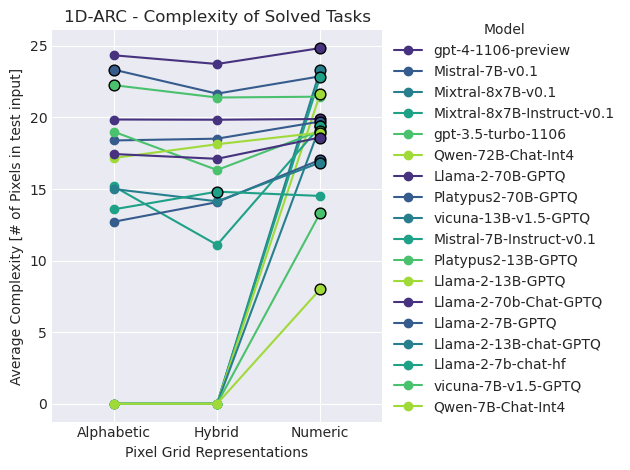

In [143]:
df = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
df['new_representation'] = df['new_representation'].replace("'.', 'a' - 'i'", 'Hybrid')
df['new_representation'] = df['new_representation'].replace("'a' - 'j'", 'Alphabetic')
df['new_representation'] = df['new_representation'].replace('0 - 9', 'Numeric')
plot_model_performance_across_runs(df, "new_representation", "avg_complexity", task="arc_1D", value_ticks=None)

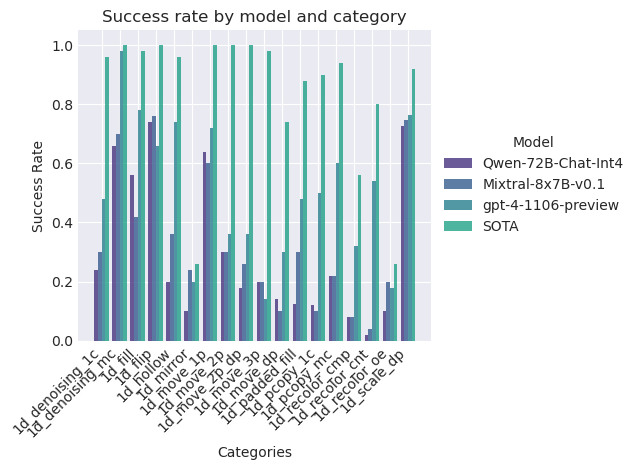

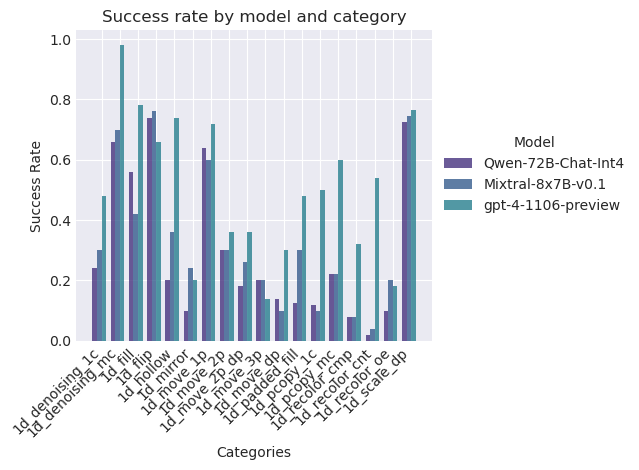

In [144]:
df = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
df = df[df["new_representation"] == "0 - 9"]
plot_grouped_bar_chart(df, top_n_models=3, SOTA=SOTA["arc_1D"])
plot_grouped_bar_chart(df, top_n_models=3, SOTA=None)


### ARC H vs V

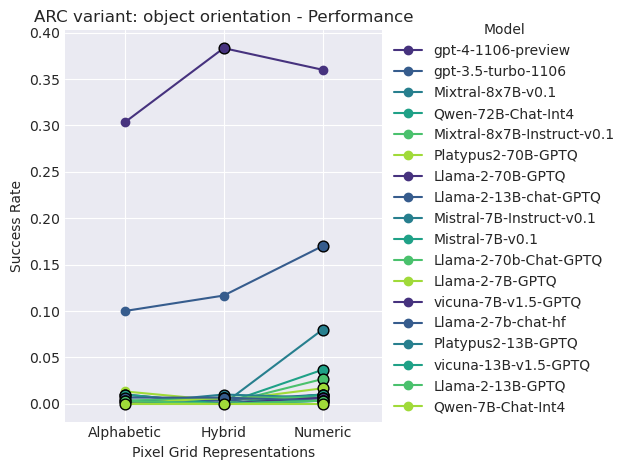

In [145]:
df = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
df['new_representation'] = df['new_representation'].replace("'.', 'a' - 'i'", 'Hybrid')
df['new_representation'] = df['new_representation'].replace("'a' - 'j'", 'Alphabetic')
df['new_representation'] = df['new_representation'].replace('0 - 9', 'Numeric')
plot_model_performance_across_runs(df, "new_representation", "success_rate", task="arc_h_v", SOTA=None, value_ticks=None)
# plot_model_performance_across_runs(df, "new_representation", "success_rate", task="arc_h_v", top_n_models=5, SOTA=SOTA, value_ticks=None)

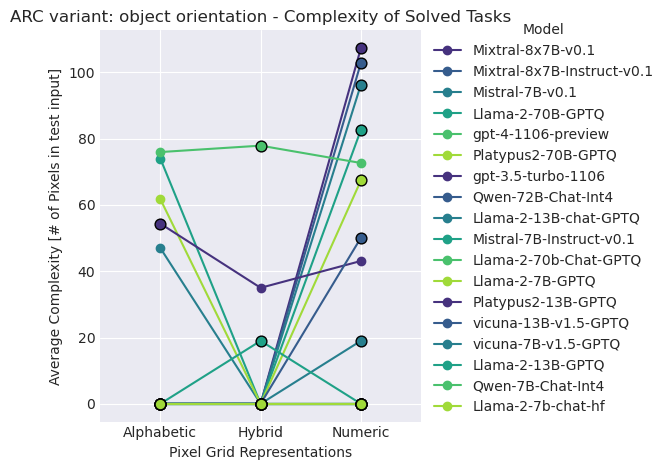

In [114]:
df = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
df['new_representation'] = df['new_representation'].replace("'.', 'a' - 'i'", 'Hybrid')
df['new_representation'] = df['new_representation'].replace("'a' - 'j'", 'Alphabetic')
df['new_representation'] = df['new_representation'].replace('0 - 9', 'Numeric')
plot_model_performance_across_runs(df, "new_representation", "avg_complexity", task="arc_h_v", value_ticks=None)

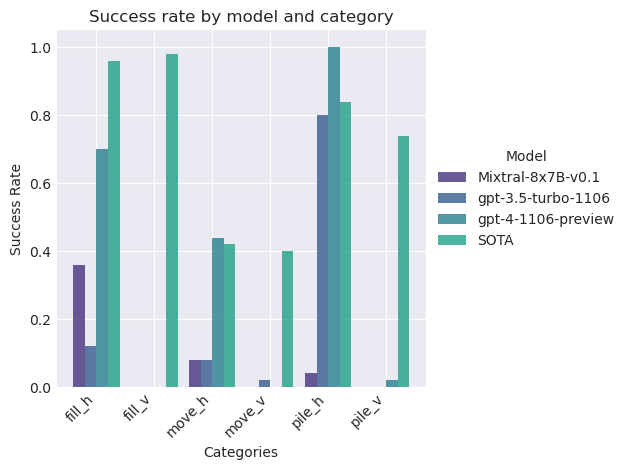

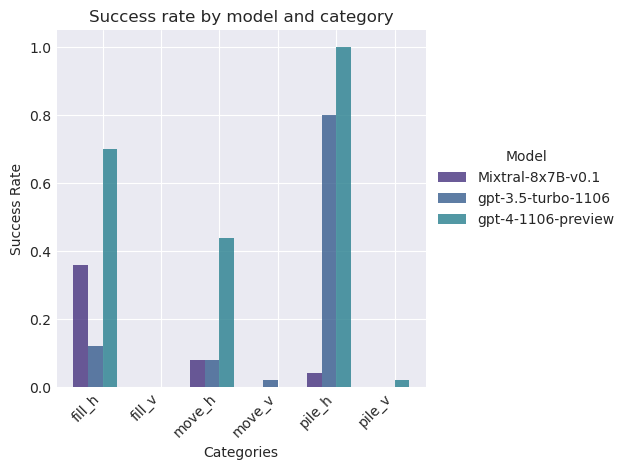

In [146]:
df = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
df = df[df["new_representation"] == "0 - 9"]
plot_grouped_bar_chart(df, top_n_models=3, SOTA=SOTA["arc_h_v"])
plot_grouped_bar_chart(df, top_n_models=3, SOTA=None)

### ARC original

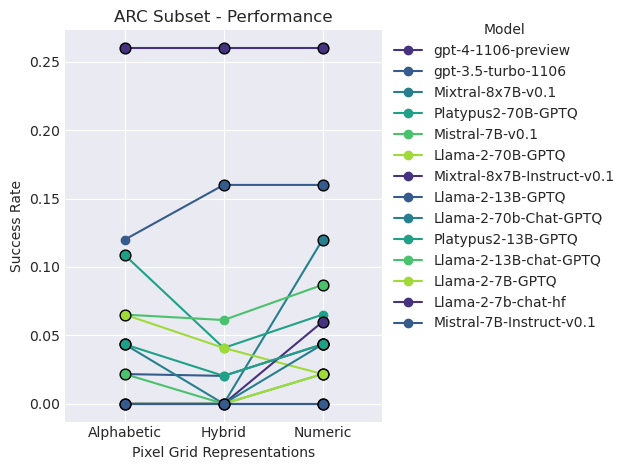

In [147]:
df = pd.read_csv("results/baseline_naive/arc/summary.csv")
df['new_representation'] = df['new_representation'].replace("'.', 'a' - 'i'", 'Hybrid')
df['new_representation'] = df['new_representation'].replace("'a' - 'j'", 'Alphabetic')
df['new_representation'] = df['new_representation'].replace('0 - 9', 'Numeric')
plot_model_performance_across_runs(df, "new_representation", "success_rate", task="arc", SOTA=None, value_ticks=None)
# plot_model_performance_across_runs(df, "new_representation", "success_rate", task="arc", top_n_models=5, SOTA=SOTA, value_ticks=None)

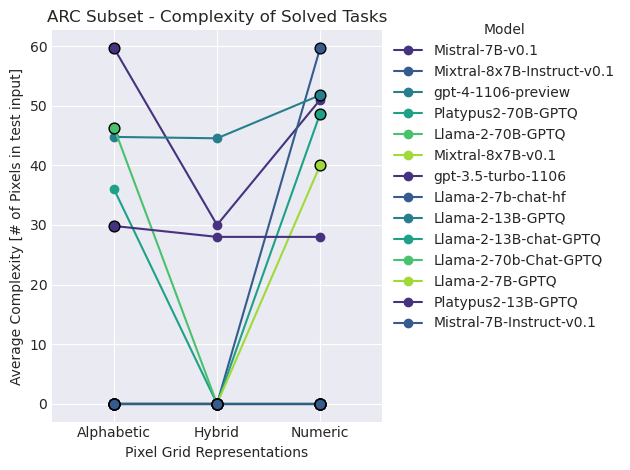

In [148]:
df = pd.read_csv("results/baseline_naive/arc/summary.csv")
df['new_representation'] = df['new_representation'].replace("'.', 'a' - 'i'", 'Hybrid')
df['new_representation'] = df['new_representation'].replace("'a' - 'j'", 'Alphabetic')
df['new_representation'] = df['new_representation'].replace('0 - 9', 'Numeric')
plot_model_performance_across_runs(df, "new_representation", "avg_complexity", task="arc", value_ticks=None)

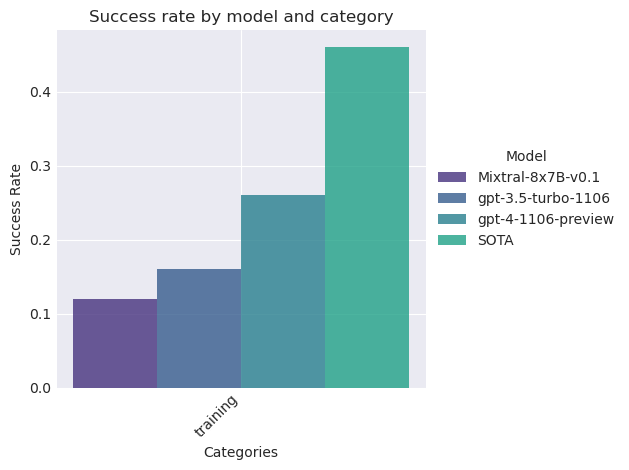

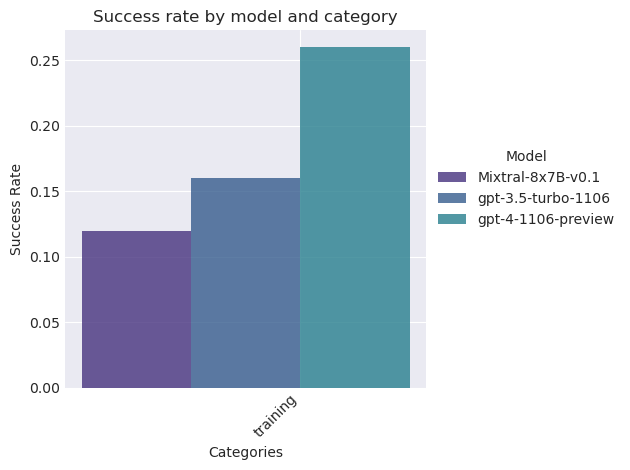

In [149]:
df = pd.read_csv("results/baseline_naive/arc/summary.csv")
df = df[df["new_representation"] == "0 - 9"]
plot_grouped_bar_chart(df, top_n_models=3, SOTA=SOTA["arc"])
plot_grouped_bar_chart(df, top_n_models=3, SOTA=None)

### All Datasets

In [99]:
# all next to each other
# df_all = []
# df_all.append(pd.read_csv("results/baseline_naive/arc/summary.csv"))
# df_all.append(pd.read_csv("results/baseline_naive/arc_1D/summary.csv"))
# df_all.append(pd.read_csv("results/baseline_naive/arc_h_v/summary.csv"))
# plot_model_performance_across_runs(df_all, "new_representation", "success_rate")

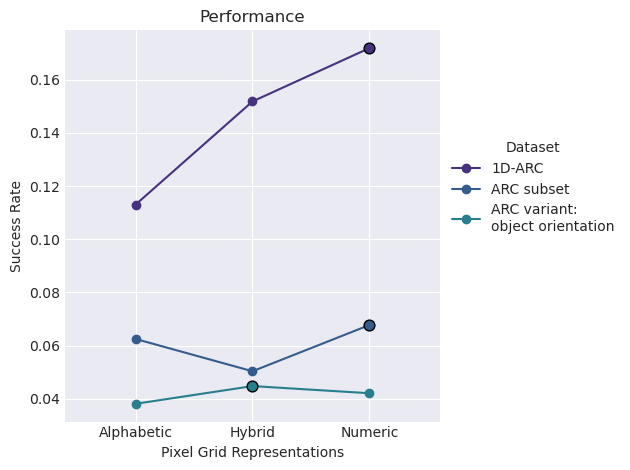

In [150]:
# Average
df_arc = pd.read_csv("results/baseline_naive/arc/summary.csv")
df_arc_1D = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
df_arc_h_v = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
df_all = pd.DataFrame()
for df in [df_arc, df_arc_1D, df_arc_h_v]:
    df = df.groupby(['new_representation', 'dataset'])['success_rate'].mean().reset_index()
    df.columns = ['new_representation', 'dataset', 'avg_success_rate']
    df_all = pd.concat([df_all, df])
df_all['new_representation'] = df_all['new_representation'].replace("'.', 'a' - 'i'", 'Hybrid')
df_all['new_representation'] = df_all['new_representation'].replace("'a' - 'j'", 'Alphabetic')
df_all['new_representation'] = df_all['new_representation'].replace('0 - 9', 'Numeric')
df_all['dataset'] = df_all['dataset'].replace('arc_1D', '1D-ARC')
df_all['dataset'] = df_all['dataset'].replace('arc_h_v', 'ARC variant:\nobject orientation')
df_all['dataset'] = df_all['dataset'].replace('arc', 'ARC subset')
plot_model_performance_across_runs(df_all, "new_representation", "avg_success_rate", "dataset", top_n_models=3, value_ticks=None)

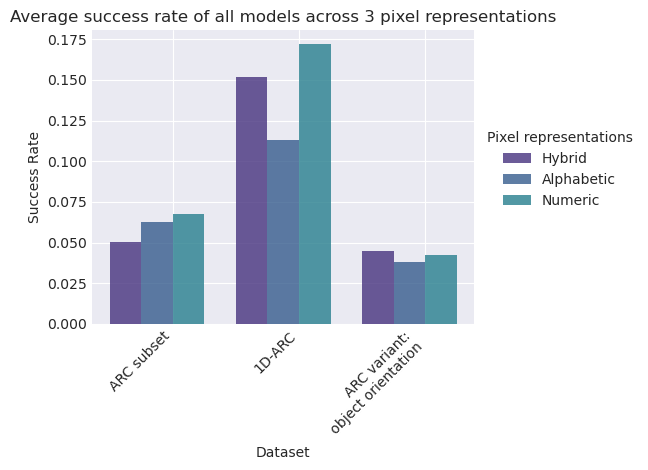

In [151]:
df_arc = pd.read_csv("results/baseline_naive/arc/summary.csv")
df_arc_1D = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
df_arc_h_v = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
df_all = pd.DataFrame()
for df in [df_arc, df_arc_1D, df_arc_h_v]:
    df = df.groupby(['new_representation', 'dataset'])['success_rate'].mean().reset_index()
    df.columns = ['new_representation', 'dataset', 'success_rate']
    df_all = pd.concat([df_all, df])
# Creating a new dataframe for the unique representations with placeholders for success rates
df_all['dataset'] = df_all['dataset'].replace('arc', 'ARC subset')
df_all['dataset'] = df_all['dataset'].replace('arc_1D', '1D-ARC')
df_all['dataset'] = df_all['dataset'].replace('arc_h_v', 'ARC variant:\n object orientation')
df_all['new_representation'] = df_all['new_representation'].replace("'.', 'a' - 'i'", 'Hybrid')
df_all['new_representation'] = df_all['new_representation'].replace("'a' - 'j'", 'Alphabetic')
df_all['new_representation'] = df_all['new_representation'].replace('0 - 9', 'Numeric')
unique_representations = df_all['new_representation'].unique()
columns = ['new_representation']
new_df = pd.DataFrame(columns=columns)
new_df['new_representation'] = unique_representations

# Populating the success rates for each dataset
for representation in unique_representations:
    for dataset in df_all["dataset"].unique():
        success_rate = df_all[(df_all['new_representation'] == str(representation)) & (df_all['dataset'] == str(dataset))]['success_rate'].max()
        new_df.loc[new_df['new_representation'] == representation, f'success_rate_{dataset}'] = success_rate

# Reset index for the new dataframe
new_df.reset_index(drop=True, inplace=True)
plot_grouped_bar_chart(new_df, group_by="new_representation", group_col="dataset", top_n_models=None)

## Baseline - CoT

### 1D ARC

#### Plots

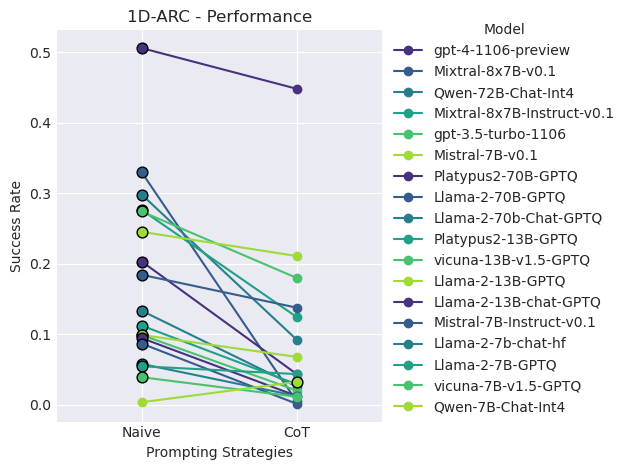

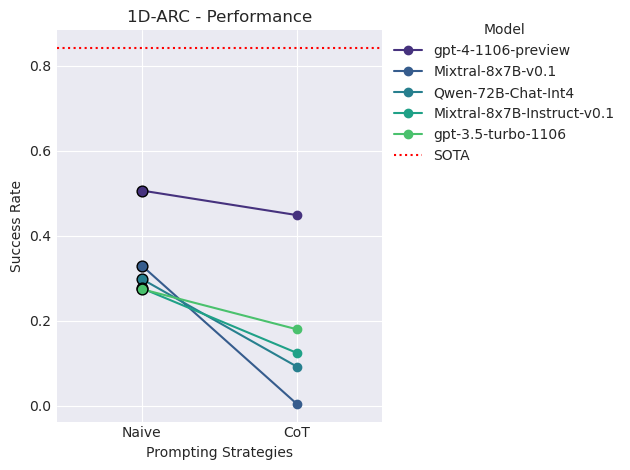

In [155]:
# All models and one of task checking methods (string or json comparison) must be correct
df_naive = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
df_cot["run"] = "CoT"
df = pd.concat([df_naive, df_cot])
plot_model_performance_across_runs(df, "run", "success_rate", task="arc_1D", SOTA=None, value_ticks=None)
plot_model_performance_across_runs(df, "run", "success_rate", task="arc_1D", top_n_models=5, SOTA=SOTA, value_ticks=None)


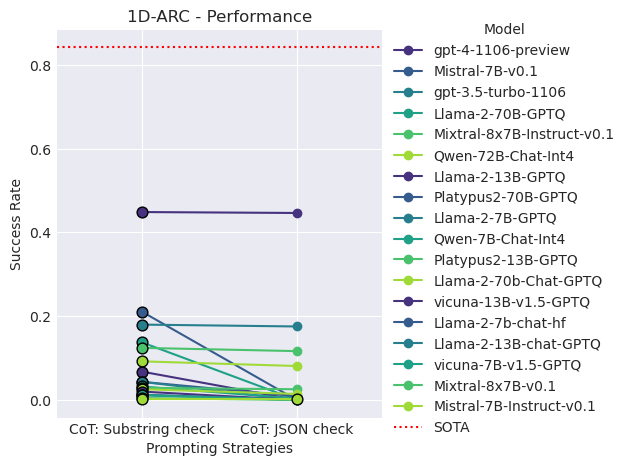

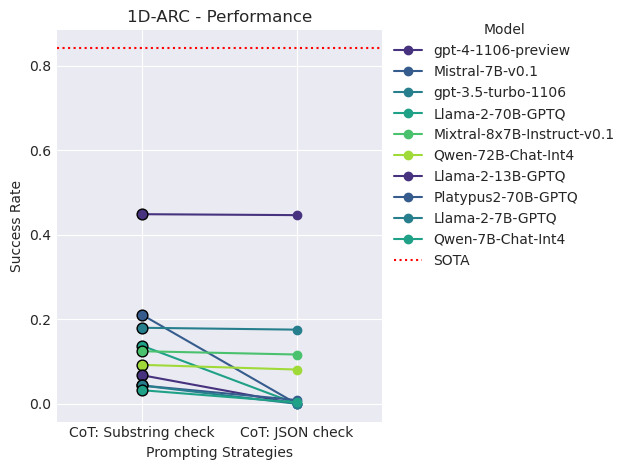

In [158]:
# String Comparison with Line Chart
df_cot = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
df_cot["run"] = "CoT: Substring check"
df_cot_wo_str = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
df_cot_wo_str["success_rate"] = df_cot_wo_str["success_rate_w/o_str_comparison"]
df_cot_wo_str["run"] = "CoT: JSON check"
df = pd.concat([df_cot, df_cot_wo_str])
plot_model_performance_across_runs(df, "run", "success_rate", task="arc_1D", SOTA=SOTA, value_ticks=None)
plot_model_performance_across_runs(df, "run", "success_rate", task="arc_1D", top_n_models=10, SOTA=SOTA, value_ticks=None)


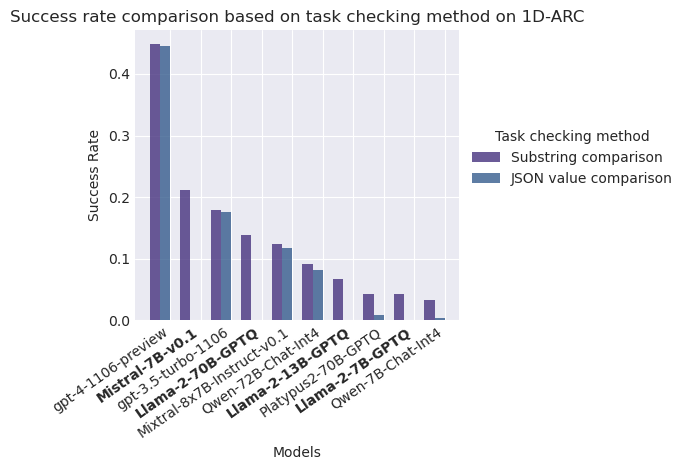

In [15]:
# String Comparison with Grouped Bar Chart
df_cot_wo_str = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
# plot_grouped_bar_chart(df_cot_wo_str, group_by=["success_rate", "success_rate_w/o_str_comparison"], group_col="str_cmp", top_n_models=None, asc=False, SOTA=None, highlight_pretrained_models=True)
plot_grouped_bar_chart(df_cot_wo_str, group_by=["success_rate", "success_rate_w/o_str_comparison"], group_col="str_cmp", top_n_models=10, asc=False, SOTA=None, highlight_pretrained_models=True)


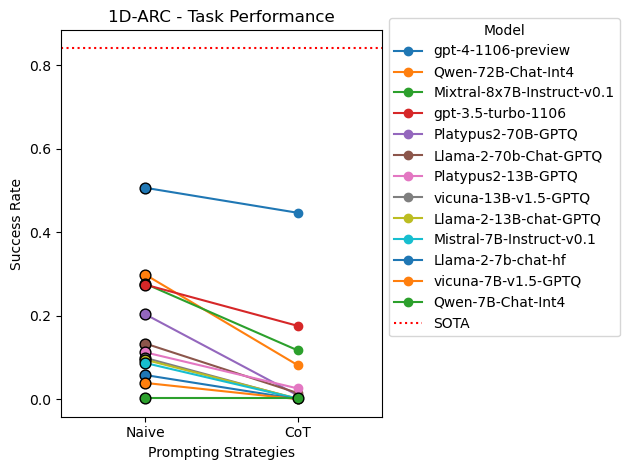

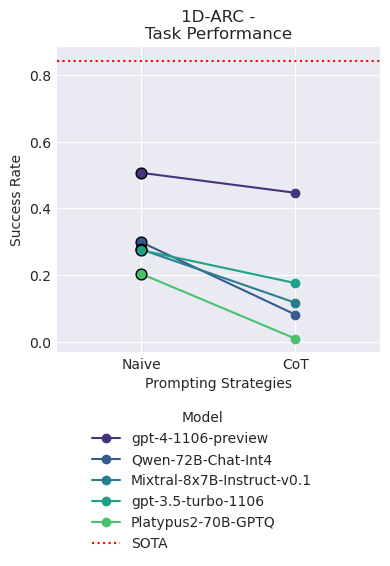

In [7]:
# Naive vs. CoT with json comparison! Only fine-tuned models!
df_naive = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot_wo_str = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
df_cot_wo_str["success_rate"] = df_cot_wo_str["success_rate_w/o_str_comparison"]
df_cot_wo_str["run"] = "CoT"
df = pd.concat([df_naive,df_cot_wo_str ])
df = df[df['model'].str.contains('gpt-', case=False, na=False) | df['model'].str.contains('Instruct', case=False, na=False) | df['model'].str.contains('Platypus', case=False, na=False) | df['model'].str.contains('chat', case=False, na=False) | df['model'].str.contains('Chat', case=False, na=False) | df['model'].str.contains('vicuna', case=False, na=False)]

plot_model_performance_across_runs(df, "run", "success_rate", task="arc_1D", SOTA=SOTA, value_ticks=None)
plot_model_performance_across_runs(df, "run", "success_rate", task="arc_1D", top_n_models=5, SOTA=SOTA, value_ticks=None, small_fig=True)


In [10]:
df[["model", "success_rate", "run"]]


model  success_rate    run
2                     gpt-3.5-turbo-1106      0.274140  Naive
14       NousResearch/Llama-2-7b-chat-hf      0.057714  Naive
18        TheBloke/Llama-2-13B-chat-GPTQ      0.094340  Naive
22        TheBloke/Llama-2-70b-Chat-GPTQ      0.133185  Naive
26    mistralai/Mistral-7B-Instruct-v0.1      0.086570  Naive
30           TheBloke/Platypus2-13B-GPTQ      0.112098  Naive
32           TheBloke/Platypus2-70B-GPTQ      0.203108  Naive
35                    gpt-4-1106-preview      0.506104  Naive
37  mistralai/Mixtral-8x7B-Instruct-v0.1      0.276360  Naive
38          TheBloke/vicuna-7B-v1.5-GPTQ      0.038846  Naive
39               Qwen/Qwen-72B-Chat-Int4      0.298109  Naive
40         TheBloke/vicuna-13B-v1.5-GPTQ      0.098779  Naive
41                Qwen/Qwen-7B-Chat-Int4      0.003330  Naive
0                     gpt-3.5-turbo-1106      0.175361    CoT
1                     gpt-4-1106-preview      0.446171    CoT
2        NousResearch/Llama-2-7b-chat-hf      0.000000    CoT
3         TheBloke/Llama-2-13B-chat-GPTQ      0.001110    CoT
5         TheBloke/Llama-2-70b-Chat-GPTQ      0.014428    CoT
9            TheBloke/Platypus2-13B-GPTQ      0.025527    CoT
10           TheBloke/Platypus2-70B-GPTQ      0.008879    CoT
11    mistralai/Mistral-7B-Instruct-v0.1      0.001110    CoT
12  mistralai/Mixtral-8x7B-Instruct-v0.1      0.116537    CoT
13               Qwen/Qwen-72B-Chat-Int4      0.081021    CoT
15          TheBloke/vicuna-7B-v1.5-GPTQ      0.000000    CoT
16         TheBloke/vicuna-13B-v1.5-GPTQ      0.000000    CoT
17                Qwen/Qwen-7B-Chat-Int4      0.003330    CoT

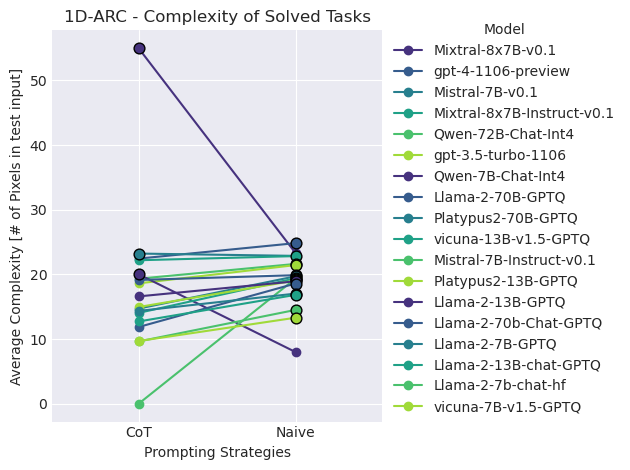

In [173]:
df_naive = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
df_cot["run"] = "CoT"
df = pd.concat([df_cot, df_naive])
plot_model_performance_across_runs(df, "run", "avg_complexity", task="arc_1D", value_ticks=None)


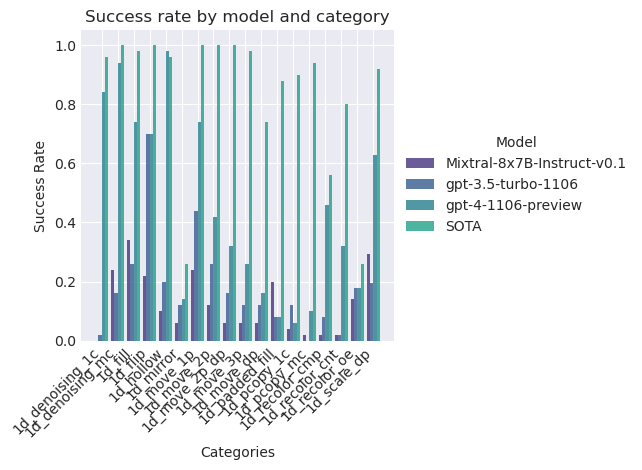

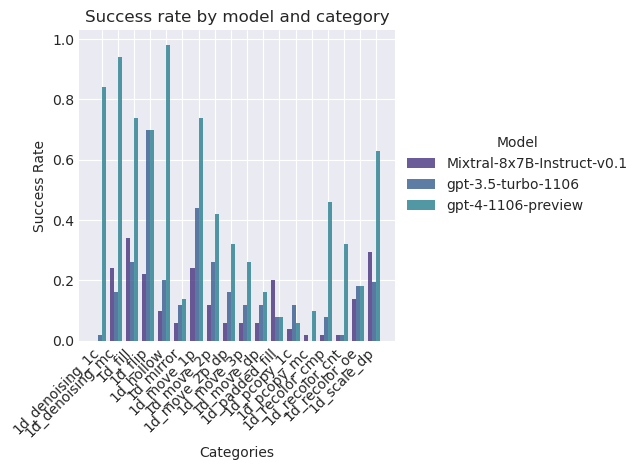

In [175]:
df = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
df = df[df['model'].str.contains('gpt-', case=False, na=False) | df['model'].str.contains('Instruct', case=False, na=False) | df['model'].str.contains('Platypus', case=False, na=False) | df['model'].str.contains('chat', case=False, na=False) | df['model'].str.contains('Chat', case=False, na=False) | df['model'].str.contains('vicuna', case=False, na=False)]
plot_grouped_bar_chart(df, top_n_models=3, SOTA=SOTA["arc_1D"])
plot_grouped_bar_chart(df, top_n_models=3, SOTA=None)

#### Chain of thought analysis

In [ ]:
# manually analyze # TODO: change data in tot src
df = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
analyze_random_tasks(df, "arc_1D", "baseline_cot", n_models=3, n_tasks=20, only_unsolved=True, only_solved=False, starting_index=0, only_save_as_txt=True)


In [6]:
path="results/baseline_cot/arc_1D/manual_task_analysis.xlsx"
task_analysis_1D, unsolved_1D, solved_1D = get_task_analysis_kpi(path)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
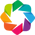

:Sankey   [source,target]   (value)

In [8]:
sankey_edges_unsolved = get_sankey_source_data(unsolved_1D)
hv.extension('bokeh')
sankey = hv.Sankey(sankey_edges_unsolved, label='1D-ARC: Chain-of-Thought Analysis of Unsolved Tasks')
sankey.opts(label_position='left', edge_color='target', node_color='index', cmap='tab20')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
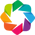

:Sankey   [source,target]   (value)

In [10]:
sankey_edges_solved = get_sankey_source_data(solved_1D)
hv.extension('bokeh')
sankey = hv.Sankey(sankey_edges_solved, label='1D-ARC: Chain-of-Thought Analysis of solved Tasks')
sankey.opts(label_position='left', edge_color='target', node_color='index', cmap='tab20')

In [9]:
from bokeh.io import export_svgs

def export_svg(obj, filename):
    plot_state = hv.renderer('bokeh').get_plot(obj).state
    plot_state.output_backend = 'svg'
    export_svgs(plot_state, filename=filename)




<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
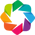

The geckodriver version (0.30.0) detected in PATH at /home/jbriem/miniconda3/envs/mixtral/bin/geckodriver might not be compatible with the detected firefox version (124.0); currently, geckodriver 0.34.0 is recommended for firefox 124.*, so it is advised to delete the driver in PATH and retry


RuntimeError: Neither firefox and geckodriver nor a variant of chromium browser and chromedriver are available on system PATH. You can install the former with 'conda install -c conda-forge firefox geckodriver'.

In [11]:
sankey_edges_both = get_sankey_source_data(pd.concat([unsolved_1D, solved_1D]))
hv.extension('bokeh')
sankey = hv.Sankey(sankey_edges_both, label='1D-ARC: Chain-of-Thought Analysis of Solved and Unsolved Tasks')
sankey.opts(label_position='left', edge_color='target', node_color='index', cmap='tab20')
hv.save(sankey, 'penguin_plot.png', fmt='png')
export_svg(sankey, "haha.svg")

### ARC H vs V

#### Plots

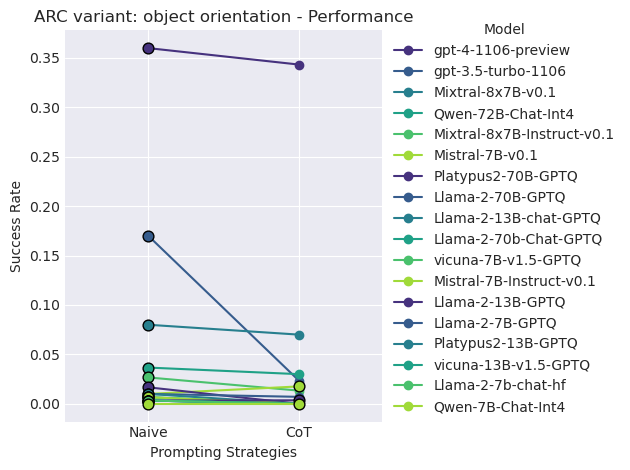

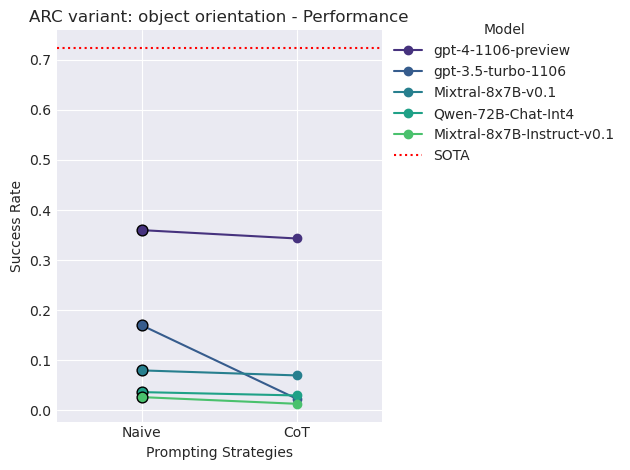

In [177]:
# All models and one of task checking methods (string or json comparison) must be correct
df_naive = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df_cot["run"] = "CoT"
df = pd.concat([df_naive, df_cot])
plot_model_performance_across_runs(df, "run", "success_rate", task="arc_h_v", SOTA=None, value_ticks=None)
plot_model_performance_across_runs(df, "run", "success_rate", task="arc_h_v", top_n_models=5, SOTA=SOTA, value_ticks=None)


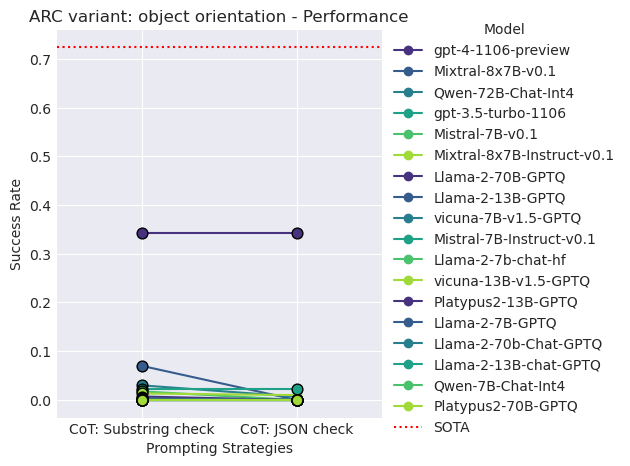

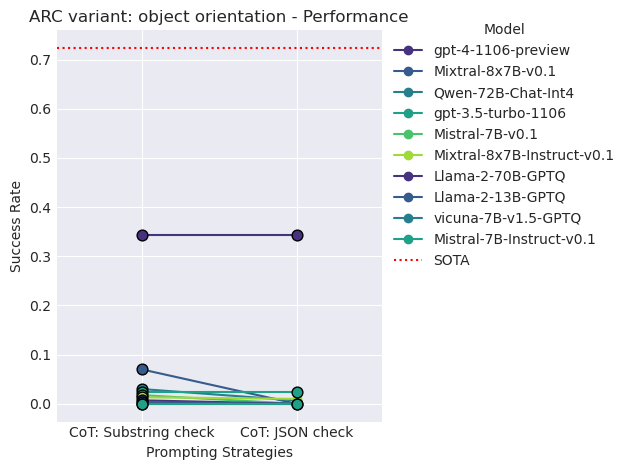

In [179]:
# String Comparison with Line Chart
df_cot = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df_cot["run"] = "CoT: Substring check"
df_cot_wo_str = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df_cot_wo_str["success_rate"] = df_cot_wo_str["success_rate_w/o_str_comparison"]
df_cot_wo_str["run"] = "CoT: JSON check"
df = pd.concat([df_cot, df_cot_wo_str])
plot_model_performance_across_runs(df, "run", "success_rate", task="arc_h_v", SOTA=SOTA, value_ticks=None)
plot_model_performance_across_runs(df, "run", "success_rate", task="arc_h_v", top_n_models=10, SOTA=SOTA, value_ticks=None)


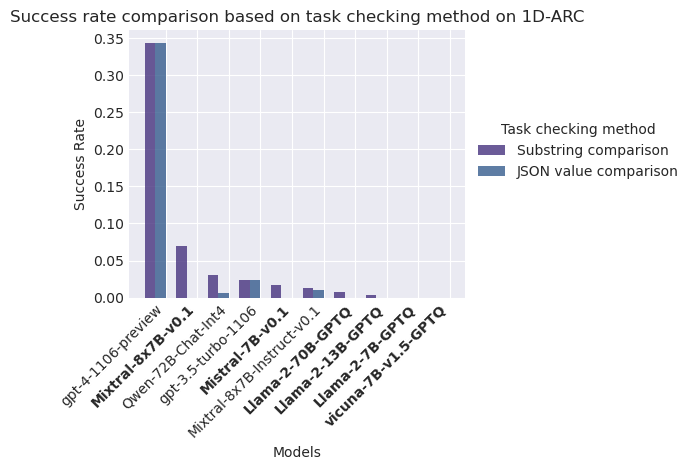

In [180]:
# String Comparison with Grouped Bar Chart
df_cot_wo_str = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
# plot_grouped_bar_chart(df_cot_wo_str, group_by=["success_rate", "success_rate_w/o_str_comparison"], group_col="str_cmp", top_n_models=None, asc=False, SOTA=None, highlight_pretrained_models=True)
plot_grouped_bar_chart(df_cot_wo_str, group_by=["success_rate", "success_rate_w/o_str_comparison"], group_col="str_cmp", top_n_models=10, asc=False, SOTA=None, highlight_pretrained_models=True)


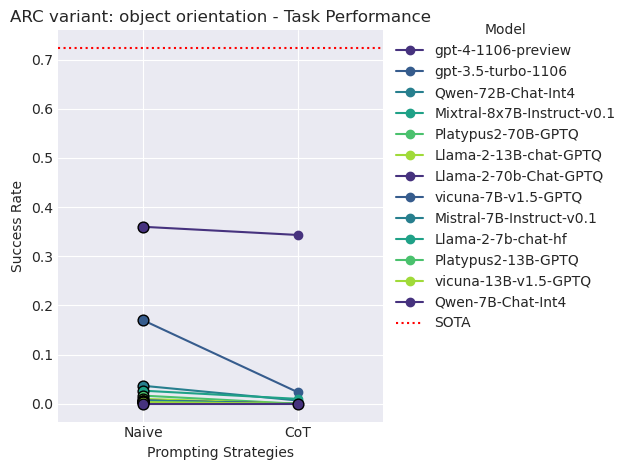

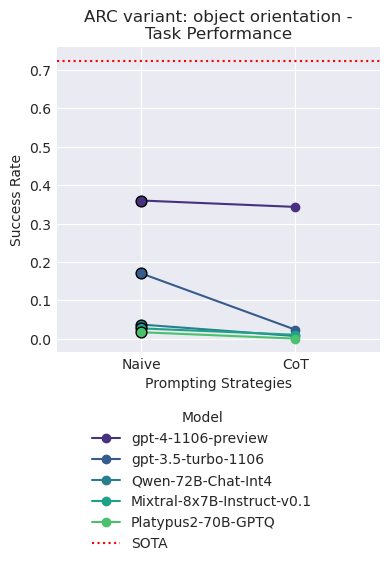

In [11]:
# Naive vs. CoT without string comparison!
df_naive = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot_wo_str = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df_cot_wo_str["success_rate"] = df_cot_wo_str["success_rate_w/o_str_comparison"]
df_cot_wo_str["run"] = "CoT"
df = pd.concat([df_naive,df_cot_wo_str ])
df = df[df['model'].str.contains('gpt-', case=False, na=False) | df['model'].str.contains('Instruct', case=False, na=False) | df['model'].str.contains('Platypus', case=False, na=False) | df['model'].str.contains('chat', case=False, na=False) | df['model'].str.contains('Chat', case=False, na=False) | df['model'].str.contains('vicuna', case=False, na=False)]
plot_model_performance_across_runs(df, "run", "success_rate", task="arc_h_v", SOTA=SOTA, value_ticks=None)
plot_model_performance_across_runs(df, "run", "success_rate", task="arc_h_v", top_n_models=5, SOTA=SOTA, value_ticks=None, small_fig=True)


In [12]:
df[["model", "success_rate", "run"]]

model  success_rate    run
2                     gpt-3.5-turbo-1106      0.170000  Naive
4                     gpt-4-1106-preview      0.360000  Naive
6        NousResearch/Llama-2-7b-chat-hf      0.003333  Naive
12        TheBloke/Llama-2-13B-chat-GPTQ      0.010000  Naive
18        TheBloke/Llama-2-70b-Chat-GPTQ      0.006667  Naive
24    mistralai/Mistral-7B-Instruct-v0.1      0.006667  Naive
29           TheBloke/Platypus2-13B-GPTQ      0.003333  Naive
32           TheBloke/Platypus2-70B-GPTQ      0.016667  Naive
37  mistralai/Mixtral-8x7B-Instruct-v0.1      0.026667  Naive
38         TheBloke/vicuna-13B-v1.5-GPTQ      0.003333  Naive
39          TheBloke/vicuna-7B-v1.5-GPTQ      0.006667  Naive
40                Qwen/Qwen-7B-Chat-Int4      0.000000  Naive
41               Qwen/Qwen-72B-Chat-Int4      0.036667  Naive
0                     gpt-3.5-turbo-1106      0.023333    CoT
1                     gpt-4-1106-preview      0.343333    CoT
2        NousResearch/Llama-2-7b-chat-hf      0.000000    CoT
3         TheBloke/Llama-2-13B-chat-GPTQ      0.000000    CoT
5         TheBloke/Llama-2-70b-Chat-GPTQ      0.000000    CoT
7            TheBloke/Platypus2-13B-GPTQ      0.000000    CoT
8            TheBloke/Platypus2-70B-GPTQ      0.000000    CoT
9     mistralai/Mistral-7B-Instruct-v0.1      0.000000    CoT
12  mistralai/Mixtral-8x7B-Instruct-v0.1      0.010000    CoT
13               Qwen/Qwen-72B-Chat-Int4      0.006667    CoT
15                Qwen/Qwen-7B-Chat-Int4      0.000000    CoT
16          TheBloke/vicuna-7B-v1.5-GPTQ      0.000000    CoT
17         TheBloke/vicuna-13B-v1.5-GPTQ      0.000000    CoT

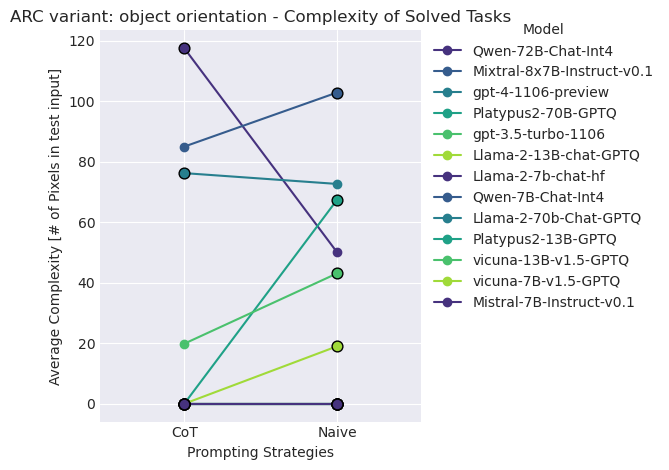

In [191]:
# TODO: Change to only success_rate_w/o_str_comparison
df_naive = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df_cot["run"] = "CoT"
df = pd.concat([df_cot, df_naive])
df = df[df['model'].str.contains('gpt-', case=False, na=False) | df['model'].str.contains('Instruct', case=False, na=False) | df['model'].str.contains('Platypus', case=False, na=False) | df['model'].str.contains('chat', case=False, na=False) | df['model'].str.contains('Chat', case=False, na=False) | df['model'].str.contains('vicuna', case=False, na=False)]
plot_model_performance_across_runs(df, "run", "avg_complexity", task="arc_h_v", value_ticks=None)


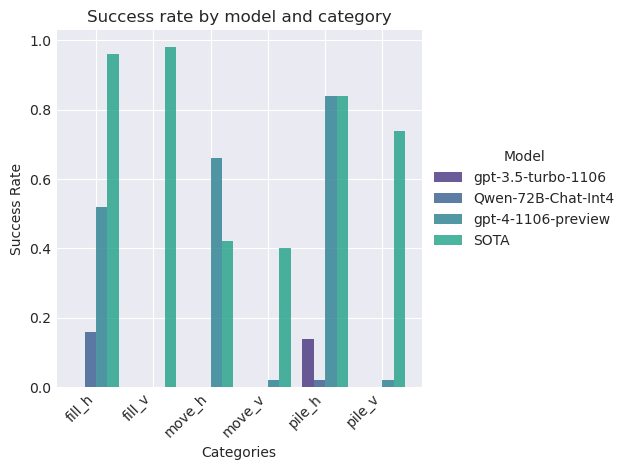

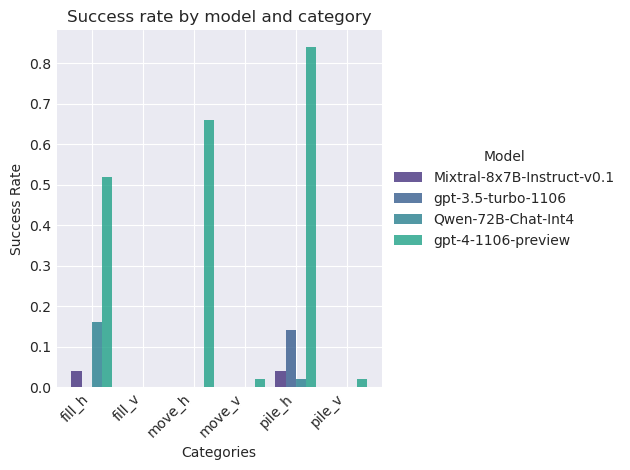

In [9]:
# TODO: Change to only success_rate_w/o_str_comparison
df = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df = df[df["new_representation"] == "0 - 9"]
df = df[df['model'].str.contains('gpt-', case=False, na=False) | df['model'].str.contains('Instruct', case=False, na=False) | df['model'].str.contains('Platypus', case=False, na=False) | df['model'].str.contains('chat', case=False, na=False) | df['model'].str.contains('Chat', case=False, na=False) | df['model'].str.contains('vicuna', case=False, na=False)]
plot_grouped_bar_chart(df, top_n_models=3, SOTA=SOTA["arc_h_v"])
plot_grouped_bar_chart(df, top_n_models=4, SOTA=None)

#### Chain of thought analysis

In [ ]:
# manually analyze # TODO: change data in tot src
df = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
analyze_random_tasks(df, "arc_h_v", "baseline_cot", n_models=3, n_tasks=20, only_unsolved=False, only_solved=True, starting_index=0, only_save_as_txt=True)


In [34]:
path="results/baseline_cot/arc_h_v/manual_task_analysis.xlsx"
task_analysis_arc_h_v, unsolved_arc_h_v, solved_arc_h_v = get_task_analysis_kpi(path)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
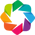

:Sankey   [source,target]   (value)

In [35]:
sankey_edges_unsolved = get_sankey_source_data(unsolved_arc_h_v)
hv.extension('bokeh')
sankey = hv.Sankey(sankey_edges_unsolved, label='ARC variant object orientation: Chain-of-Thought Analysis of Unsolved Tasks')
sankey.opts(label_position='left', edge_color='target', node_color='index', cmap='tab20')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
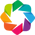

:Sankey   [source,target]   (value)

In [36]:
sankey_edges_solved = get_sankey_source_data(solved_arc_h_v)
hv.extension('bokeh')
sankey = hv.Sankey(sankey_edges_solved, label='ARC variant object orientation: Chain-of-Thought Analysis of solved Tasks')
sankey.opts(label_position='left', edge_color='target', node_color='index', cmap='tab20')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
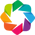

:Sankey   [source,target]   (value)

In [37]:
sankey_edges_both = get_sankey_source_data(pd.concat([unsolved_arc_h_v, solved_arc_h_v]))
hv.extension('bokeh')
sankey = hv.Sankey(sankey_edges_both, label='ARC variant object orientation: Chain-of-Thought Analysis of Solved and Unsolved Tasks')
sankey.opts(label_position='left', edge_color='target', node_color='index', cmap='tab20')

### ARC original

#### Plots

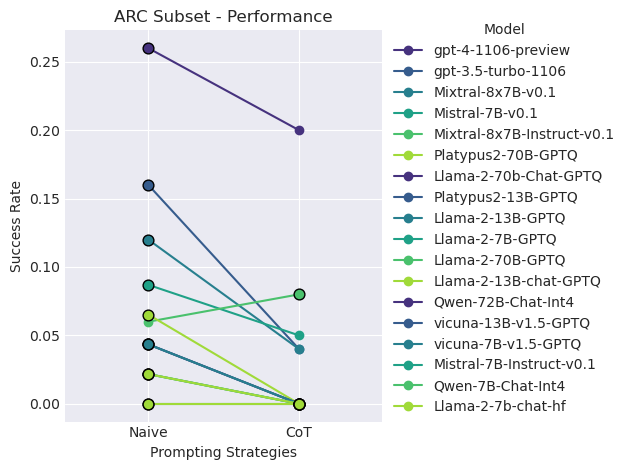

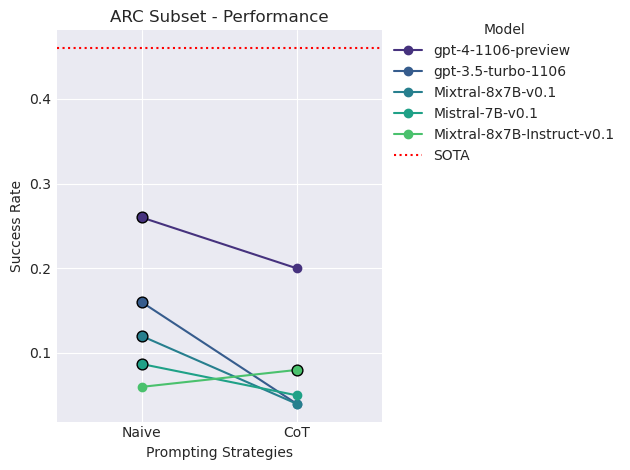

In [193]:
# All models and one of task checking methods (string or json comparison) must be correct
df_naive = pd.read_csv("results/baseline_naive/arc/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc/summary.csv")
df_cot["run"] = "CoT"
df = pd.concat([df_naive, df_cot])

plot_model_performance_across_runs(df, "run", "success_rate", task="arc", SOTA=None, value_ticks=None)
plot_model_performance_across_runs(df, "run", "success_rate", task="arc", top_n_models=5, SOTA=SOTA, value_ticks=None)


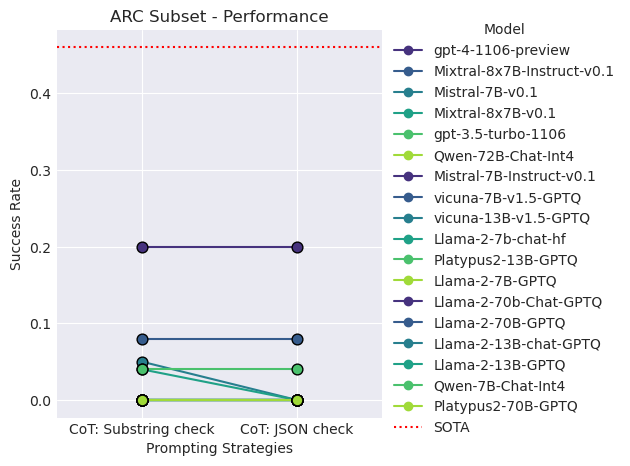

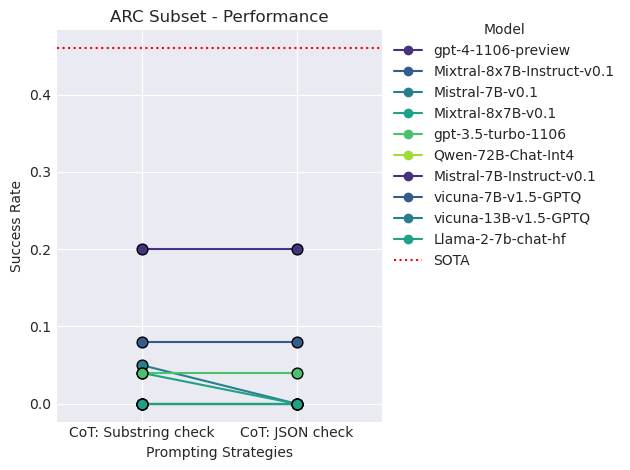

In [195]:
# String Comparison with Line Chart
df_cot = pd.read_csv("results/baseline_cot/arc/summary.csv")
df_cot["run"] = "CoT: Substring check"
df_cot_wo_str = pd.read_csv("results/baseline_cot/arc/summary.csv")
df_cot_wo_str["success_rate"] = df_cot_wo_str["success_rate_w/o_str_comparison"]
df_cot_wo_str["run"] = "CoT: JSON check"
df = pd.concat([df_cot, df_cot_wo_str])
plot_model_performance_across_runs(df, "run", "success_rate", task="arc", SOTA=SOTA, value_ticks=None)
plot_model_performance_across_runs(df, "run", "success_rate", task="arc", top_n_models=10, SOTA=SOTA, value_ticks=None)




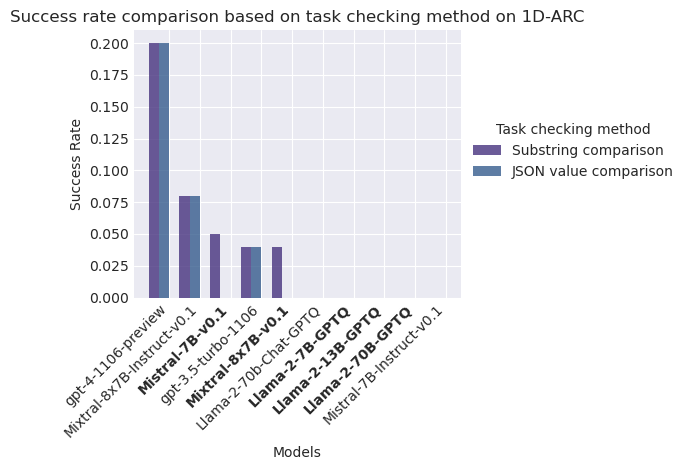

In [196]:
# String Comparison with Grouped Bar Chart
df_cot_wo_str = pd.read_csv("results/baseline_cot/arc/summary.csv")
# plot_grouped_bar_chart(df_cot_wo_str, group_by=["success_rate", "success_rate_w/o_str_comparison"], group_col="str_cmp", top_n_models=None, asc=False, SOTA=None, highlight_pretrained_models=True)
plot_grouped_bar_chart(df_cot_wo_str, group_by=["success_rate", "success_rate_w/o_str_comparison"], group_col="str_cmp", top_n_models=10, asc=False, SOTA=None, highlight_pretrained_models=True)


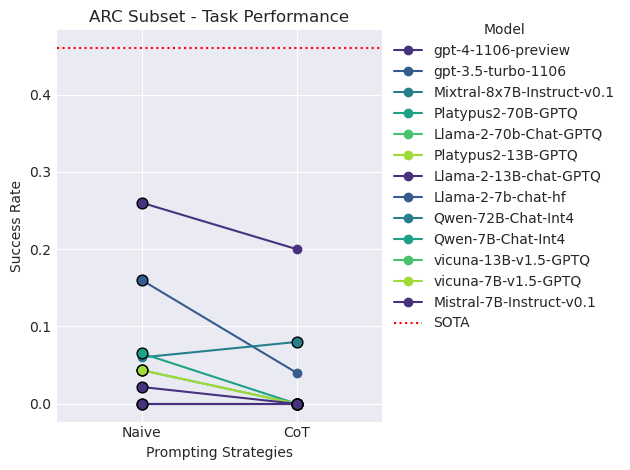

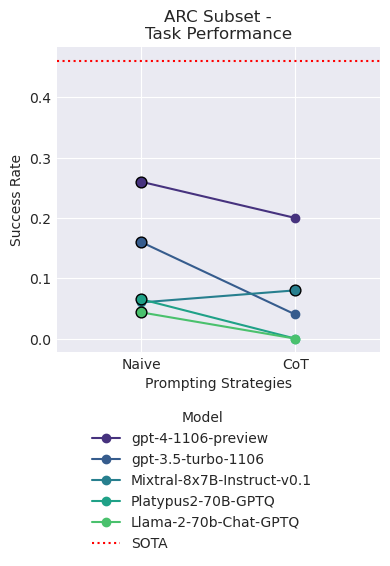

In [13]:
# Naive vs. CoT without string comparison!
df_naive = pd.read_csv("results/baseline_naive/arc/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot_wo_str = pd.read_csv("results/baseline_cot/arc/summary.csv")
df_cot_wo_str["success_rate"] = df_cot_wo_str["success_rate_w/o_str_comparison"]
df_cot_wo_str["run"] = "CoT"
df = pd.concat([df_naive,df_cot_wo_str ])
df = df[df['model'].str.contains('gpt-', case=False, na=False) | df['model'].str.contains('Instruct', case=False, na=False) | df['model'].str.contains('Platypus', case=False, na=False) | df['model'].str.contains('chat', case=False, na=False) | df['model'].str.contains('Chat', case=False, na=False) | df['model'].str.contains('vicuna', case=False, na=False)]

plot_model_performance_across_runs(df, "run", "success_rate", task="arc", SOTA=SOTA, value_ticks=None)
plot_model_performance_across_runs(df, "run", "success_rate", task="arc", top_n_models=5, SOTA=SOTA, value_ticks=None, small_fig=True)


In [14]:
df[[ "model", "success_rate", "run"]]

model  success_rate    run
0                     gpt-3.5-turbo-1106      0.160000  Naive
3        NousResearch/Llama-2-7b-chat-hf      0.000000  Naive
9         TheBloke/Llama-2-13B-chat-GPTQ      0.021739  Naive
15        TheBloke/Llama-2-70b-Chat-GPTQ      0.043478  Naive
21    mistralai/Mistral-7B-Instruct-v0.1      0.000000  Naive
27           TheBloke/Platypus2-13B-GPTQ      0.043478  Naive
30           TheBloke/Platypus2-70B-GPTQ      0.065217  Naive
33                    gpt-4-1106-preview      0.260000  Naive
37  mistralai/Mixtral-8x7B-Instruct-v0.1      0.060000  Naive
0                     gpt-3.5-turbo-1106      0.040000    CoT
1                     gpt-4-1106-preview      0.200000    CoT
2        NousResearch/Llama-2-7b-chat-hf      0.000000    CoT
3         TheBloke/Llama-2-13B-chat-GPTQ      0.000000    CoT
4         TheBloke/Llama-2-70b-Chat-GPTQ      0.000000    CoT
8     mistralai/Mistral-7B-Instruct-v0.1      0.000000    CoT
10           TheBloke/Platypus2-13B-GPTQ      0.000000    CoT
11           TheBloke/Platypus2-70B-GPTQ      0.000000    CoT
12  mistralai/Mixtral-8x7B-Instruct-v0.1      0.080000    CoT
13               Qwen/Qwen-72B-Chat-Int4      0.000000    CoT
14                Qwen/Qwen-7B-Chat-Int4      0.000000    CoT
15          TheBloke/vicuna-7B-v1.5-GPTQ      0.000000    CoT
16         TheBloke/vicuna-13B-v1.5-GPTQ      0.000000    CoT

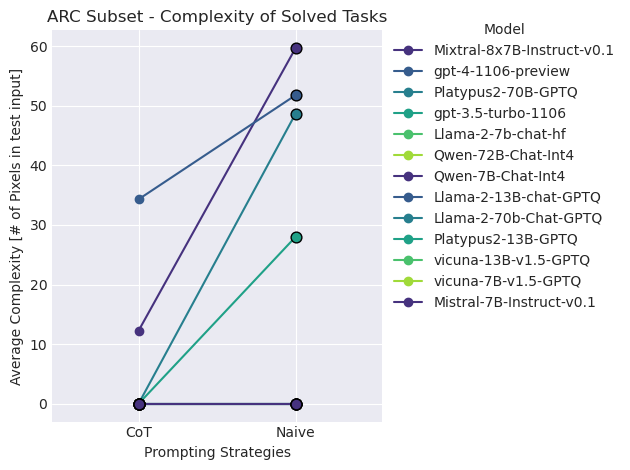

In [199]:
df_naive = pd.read_csv("results/baseline_naive/arc/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc/summary.csv")
df_cot["run"] = "CoT"
df = pd.concat([df_cot, df_naive])
df = df[df['model'].str.contains('gpt-', case=False, na=False) | df['model'].str.contains('Instruct', case=False, na=False) | df['model'].str.contains('Platypus', case=False, na=False) | df['model'].str.contains('chat', case=False, na=False) | df['model'].str.contains('Chat', case=False, na=False) | df['model'].str.contains('vicuna', case=False, na=False)]
plot_model_performance_across_runs(df, "run", "avg_complexity", task="arc", value_ticks=None)


#### Chain of thought analysis

In [ ]:
# manually analyze
df = pd.read_csv("results/baseline_cot/arc/summary.csv")
analyze_random_tasks(df, "arc", "baseline_cot", n_models=3, n_tasks=20, only_unsolved=False, only_solved=True, starting_index=0, only_save_as_txt=True)


In [39]:
path="results/baseline_cot/arc/manual_task_analysis.xlsx"
path="results/baseline_cot/arc_h_v/manual_task_analysis.xlsx"
task_analysis_arc, unsolved_arc, solved_arc  = get_task_analysis_kpi(path)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
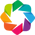

:Sankey   [source,target]   (value)

In [40]:
sankey_edges_unsolved = get_sankey_source_data(unsolved_1D)
hv.extension('bokeh')
sankey = hv.Sankey(sankey_edges_unsolved, label='1D-ARC: Chain-of-Thought Analysis of Unsolved Tasks')
sankey.opts(label_position='left', edge_color='target', node_color='index', cmap='tab20')

In [43]:
sankey_edges_both

source                target      value
0                  tasks   description correct  13.333333
1                  tasks     description wrong  86.666667
2    description correct       pattern correct  11.666667
3    description correct         pattern wrong   1.666667
4      description wrong       pattern correct   6.666667
5      description wrong         pattern wrong       80.0
6        pattern correct  instructions correct  18.333333
9          pattern wrong    instructions wrong  81.666667
10  instructions correct        output correct  18.333333
13    instructions wrong        output correct  31.666667
14    instructions wrong          output wrong       50.0

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
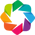

:Sankey   [source,target]   (value)

In [42]:
sankey_edges_both = get_sankey_source_data(pd.concat([unsolved_1D, solved_1D]))
hv.extension('bokeh')
sankey = hv.Sankey(sankey_edges_both, label='1D-ARC: Chain-of-Thought Analysis of Solved and Unsolved Tasks')
sankey.opts(label_position='left', edge_color='target', node_color='index', cmap='tab20')

### All

In [200]:
# all next to each other
# df_all = []
# df_naive = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
# df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
# df_naive["run"] = "Naive"
# df_cot_wo_str = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
# df_cot_wo_str["success_rate"] = df_cot_wo_str["success_rate_w/o_str_comparison"]
# df_cot_wo_str["run"] = "CoT"
# df = pd.concat([df_naive,df_cot_wo_str ])
# df = df[df['model'].str.contains('gpt-', case=False, na=False) | df['model'].str.contains('Instruct', case=False, na=False) | df['model'].str.contains('Platypus', case=False, na=False) | df['model'].str.contains('chat', case=False, na=False) | df['model'].str.contains('Chat', case=False, na=False) | df['model'].str.contains('vicuna', case=False, na=False)]

# df_all.append(pd.read_csv("results/baseline_cot/arc_1D/summary.csv"))
# df_all.append(pd.read_csv("results/baseline_cot/arc_h_v/summary.csv"))
# plot_model_performance_across_runs(df_all, "run", "success_rate")

## Tree of Thought

### 1D ARC

#### Plots

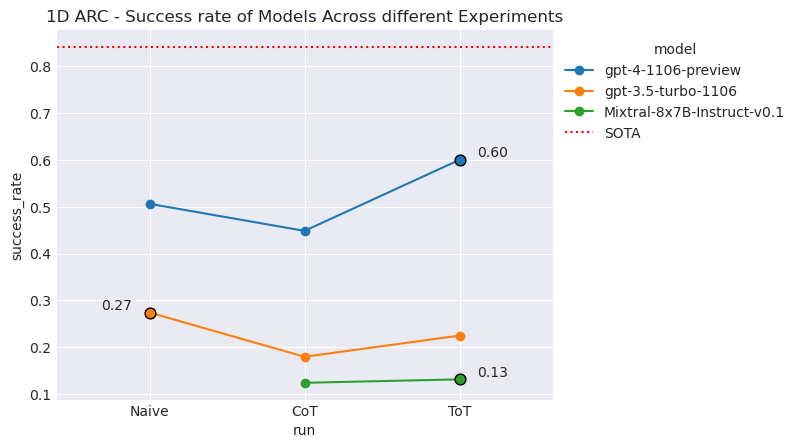

In [8]:
df_naive = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
df_cot["run"] = "CoT"
df_tot = pd.read_csv("results/tot_normal/arc_1D/summary.csv")
df_tot["run"] = "ToT"
df = pd.concat([df_naive, df_cot, df_tot])
filtered_df = df[df['model'].str.contains('gpt-', case=False, na=False) | df['model'].str.contains('Mixtral-8x7B-Instruct', case=False, na=False)]
plot_model_performance_across_runs(filtered_df, "run", "success_rate", task="arc_1D", SOTA=SOTA)

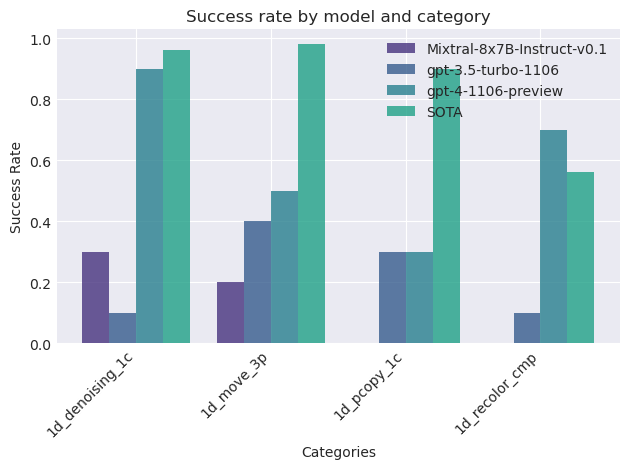

In [9]:
# compare tot of different models
df_tot = pd.read_csv("results/tot_normal/arc_1D/summary.csv")
plot_grouped_bar_chart(df_tot, top_n_models=3, SOTA=SOTA["arc_1D"])


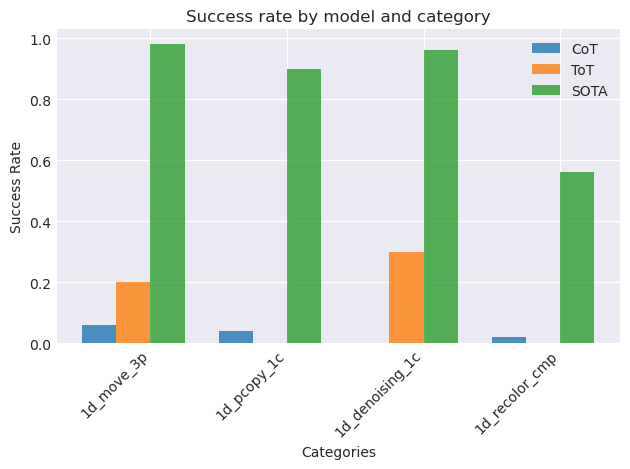

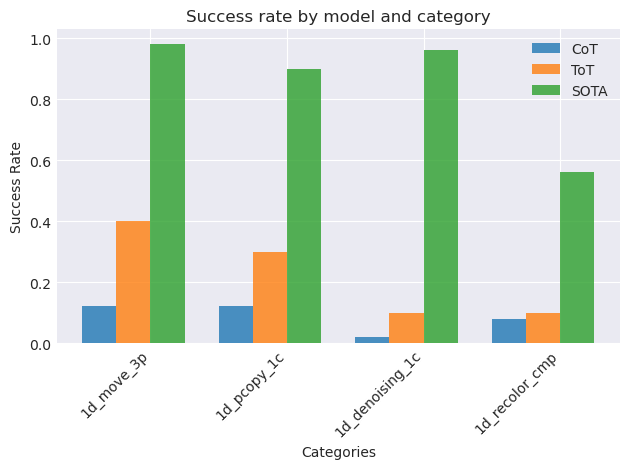

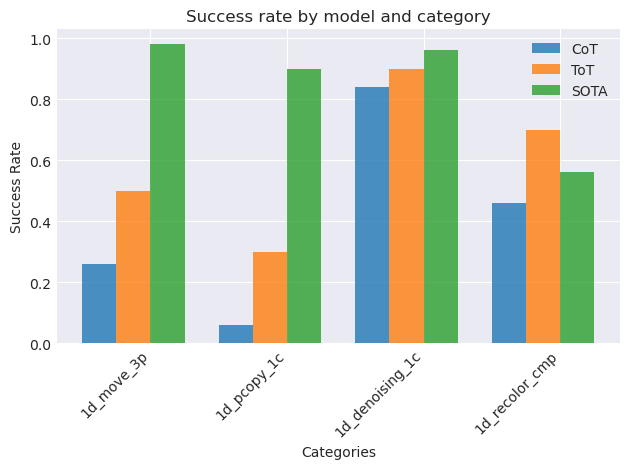

In [15]:
# compare cot and tot of single models
models = ["gpt-3", "gpt-4", "Mixtral-8x7B-Instruct"]
dfs = {}
df_cot = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
df_tot = pd.read_csv("results/tot_normal/arc_1D/summary.csv")
for m in models:
    df_cot_tmp = df_cot[df_cot['model'].str.contains(m, case=False, na=False)]
    df_cot_tmp["model"] = "CoT"
    df_tot_tmp = df_tot[df_tot['model'].str.contains(m, case=False, na=False)]
    df_tot_tmp["model"] = "ToT"
    columns = list(set(df_tot_tmp.columns).intersection(set(df_cot_tmp.columns)))
    df_cot_tmp = df_cot_tmp[columns]
    dfs[m] = pd.concat([df_cot_tmp, df_tot_tmp])

plot_grouped_bar_chart(dfs["Mixtral-8x7B-Instruct"], top_n_models=2, SOTA=SOTA["arc_1D"])
plot_grouped_bar_chart(dfs["gpt-3"], top_n_models=2, SOTA=SOTA["arc_1D"])
plot_grouped_bar_chart(dfs["gpt-4"], top_n_models=2, SOTA=SOTA["arc_1D"])


### ARC H vs V

#### Plots

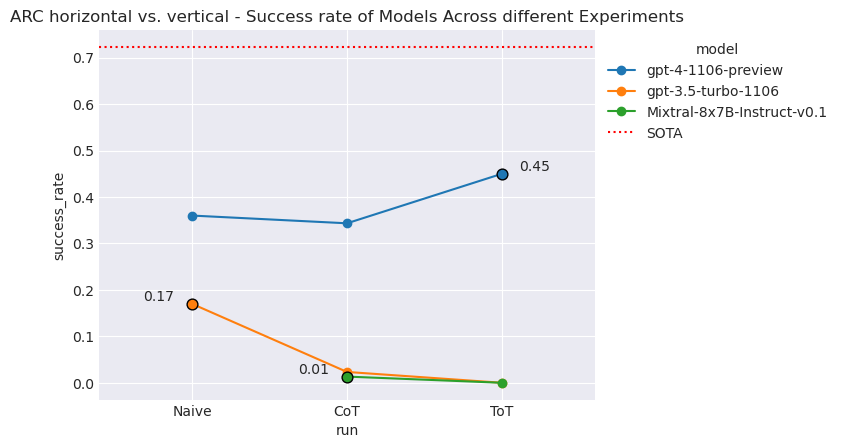

In [16]:
df_naive = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df_cot["run"] = "CoT"
df_tot = pd.read_csv("results/tot_normal/arc_h_v/summary.csv")
df_tot["run"] = "ToT"
df = pd.concat([df_naive, df_cot, df_tot])
filtered_df = df[df['model'].str.contains('gpt-', case=False, na=False) | 
                 df['model'].str.contains('Mixtral-8x7B-Instruct', case=False, na=False)]
plot_model_performance_across_runs(filtered_df, "run", "success_rate", task="arc_h_v", SOTA=SOTA)

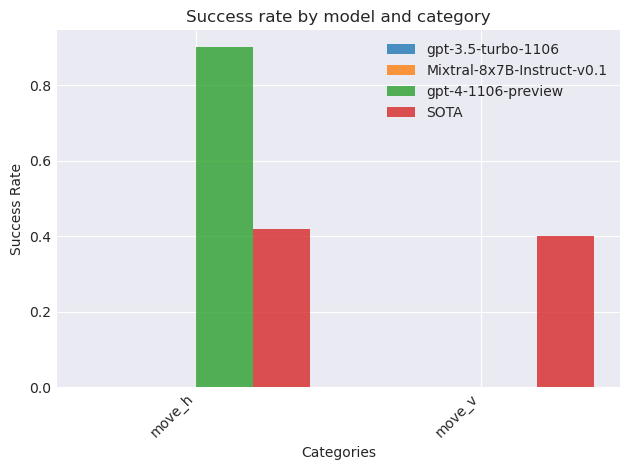

In [17]:
# compare tot of different models
df_tot = pd.read_csv("results/tot_normal/arc_h_v/summary.csv")
plot_grouped_bar_chart(df_tot, top_n_models=3, SOTA=SOTA["arc_h_v"])


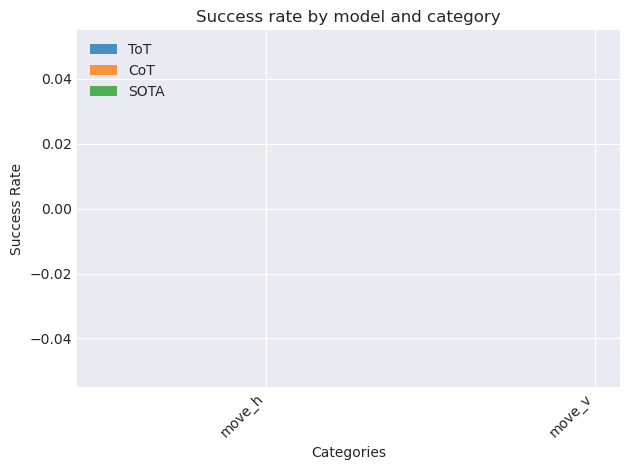

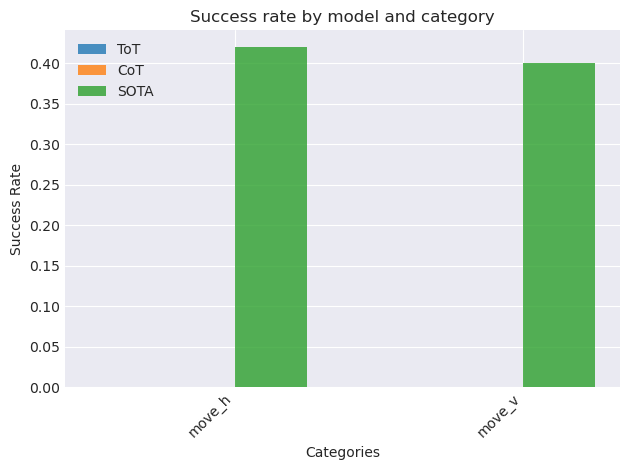

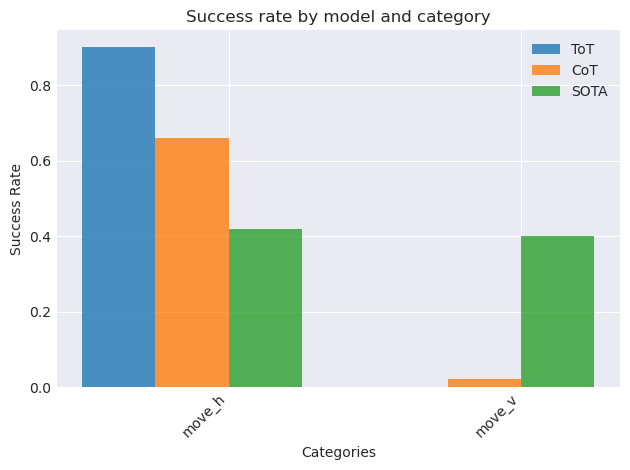

In [20]:
# compare cot and tot of single models
models = ["gpt-3", "gpt-4", "Mixtral-8x7B-Instruct"]
dfs = {}
df_cot = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df_tot = pd.read_csv("results/tot_normal/arc_h_v/summary.csv")
for m in models:
    df_cot_tmp = df_cot[df_cot['model'].str.contains(m, case=False, na=False)]
    df_cot_tmp["model"] = "CoT"
    df_tot_tmp = df_tot[df_tot['model'].str.contains(m, case=False, na=False)]
    df_tot_tmp["model"] = "ToT"
    filter_cols = [col for col in df_tot_tmp.columns if "cat" in col] + ["model"]
    df_cot_tmp = df_cot_tmp[filter_cols]
    dfs[m] = pd.concat([df_cot_tmp, df_tot_tmp])

plot_grouped_bar_chart(dfs["Mixtral-8x7B-Instruct"], top_n_models=2, SOTA=SOTA["arc_1D"])
plot_grouped_bar_chart(dfs["gpt-3"], top_n_models=2, SOTA=SOTA["arc_h_v"])
plot_grouped_bar_chart(dfs["gpt-4"], top_n_models=2, SOTA=SOTA["arc_h_v"])


### ARC original

## CoT with Object Representation

### 1D ARC

#### Plots

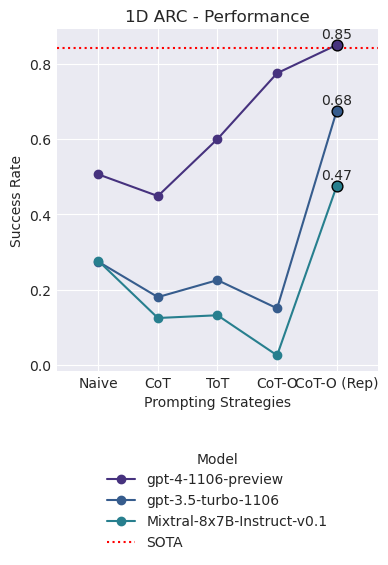

In [241]:
df_naive = pd.read_csv("results/baseline_naive/arc_1D/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
df_cot["run"] = "CoT"
df_tot = pd.read_csv("results/tot_normal/arc_1D/summary.csv")
df_tot["run"] = "ToT"
df_cot_o = pd.read_csv("results/cot_objects/arc_1D/summary.csv")
df_cot_o["run"] = "CoT-O"
df_cot_o_rep = pd.read_csv("results/cot_objects/arc_1D/summary.csv")
df_cot_o_rep["success_rate"] = df_cot_o_rep["object_info_object_representation_success_rate"]
df_cot_o_rep["run"] = "CoT-O (Rep)"
df = pd.concat([df_naive, df_cot, df_tot,df_cot_o, df_cot_o_rep])
filtered_df = df[df['model'].str.contains('gpt-', case=False, na=False) | df['model'].str.contains('Mixtral-8x7B-Instruct', case=False, na=False)]
plot_model_performance_across_runs(filtered_df, "run", "success_rate", task="arc_1D", SOTA=SOTA)

##### Same Run: grid output vs. object cmp

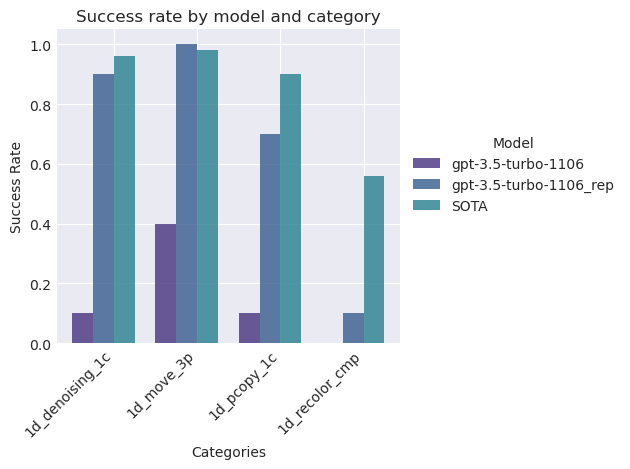

In [242]:
# compare cot_o overall result vs. object representation of output correct  --- GPT 3
df_cot_o = pd.read_csv("results/cot_objects/arc_1D/summary.csv")
df_cot_o_rep = df_cot_o.copy()
df_cot_o_rep["model"] = df_cot_o_rep["model"] + "_rep"
df_cot_o_rep = df_cot_o_rep.loc[:, ~df_cot_o_rep.columns.str.startswith('cat_success')]
rename_cols = {col: col.replace('object_info_object_representation_', '') 
               for col in df_cot_o_rep.columns if col.startswith('object_info_object_representation_cat_success_rate')}
df_cot_o_rep = df_cot_o_rep.rename(columns=rename_cols)
df = pd.concat([df_cot_o, df_cot_o_rep])
filtered_df = df[df['model'].str.contains('gpt-3', case=False, na=False)]
plot_grouped_bar_chart(filtered_df, top_n_models=2, SOTA=SOTA["arc_1D"])


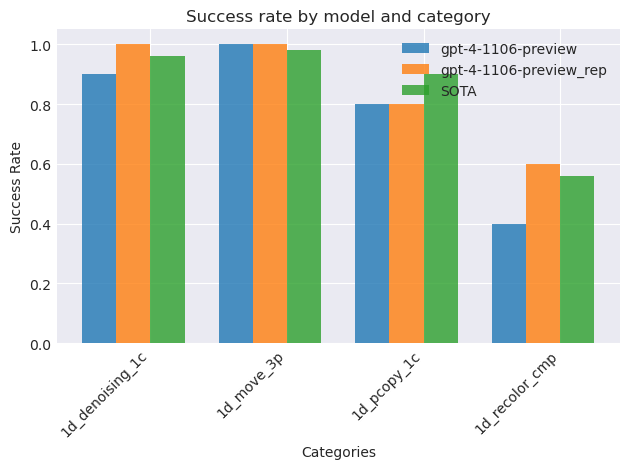

In [18]:
# compare cot_o overall result vs. object representation of output correct  --- GPT 4
df_cot_o = pd.read_csv("results/cot_objects/arc_1D/summary.csv")
df_cot_o_rep = df_cot_o.copy()
df_cot_o_rep["model"] = df_cot_o_rep["model"] + "_rep"
df_cot_o_rep = df_cot_o_rep.loc[:, ~df_cot_o_rep.columns.str.startswith('cat_success')]
rename_cols = {col: col.replace('object_info_object_representation_', '') 
               for col in df_cot_o_rep.columns if col.startswith('object_info_object_representation_cat_success_rate')}
df_cot_o_rep = df_cot_o_rep.rename(columns=rename_cols)
df = pd.concat([df_cot_o, df_cot_o_rep])
filtered_df = df[df['model'].str.contains('gpt-4', case=False, na=False)]
plot_grouped_bar_chart(filtered_df, top_n_models=2, SOTA=SOTA["arc_1D"])


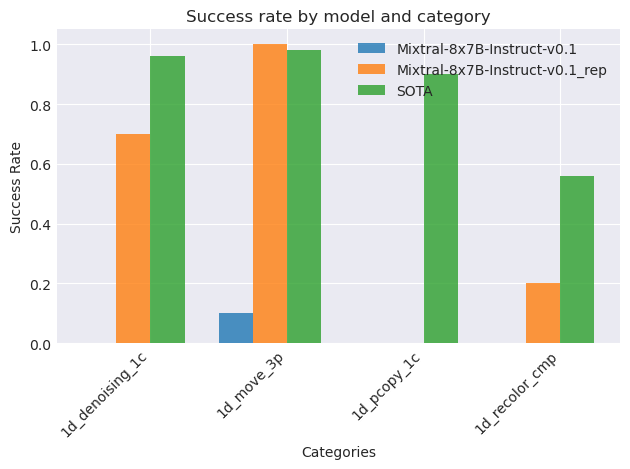

In [19]:
# compare cot_o overall result vs. object representation of output correct  --- Mixtral
df_cot_o = pd.read_csv("results/cot_objects/arc_1D/summary.csv")
df_cot_o_rep = df_cot_o.copy()
df_cot_o_rep["model"] = df_cot_o_rep["model"] + "_rep"
df_cot_o_rep = df_cot_o_rep.loc[:, ~df_cot_o_rep.columns.str.startswith('cat_success')]
rename_cols = {col: col.replace('object_info_object_representation_', '') 
               for col in df_cot_o_rep.columns if col.startswith('object_info_object_representation_cat_success_rate')}
df_cot_o_rep = df_cot_o_rep.rename(columns=rename_cols)
df = pd.concat([df_cot_o, df_cot_o_rep])
filtered_df = df[df['model'].str.contains('Mixtral-8x7B-Instruct', case=False, na=False)]
plot_grouped_bar_chart(filtered_df, top_n_models=2, SOTA=SOTA["arc_1D"])


##### Different Runs: normal CoT vs. object cmp 

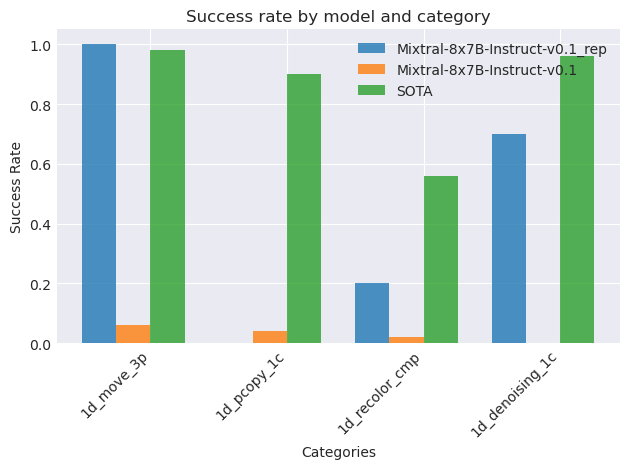

In [22]:
# compare cot_o overall result vs. object representation of output correct  --- Mixtral
df_cot = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
df_cot_o = pd.read_csv("results/cot_objects/arc_1D/summary.csv")
df_cot_o_rep = df_cot_o.copy()
df_cot_o_rep["model"] = df_cot_o_rep["model"] + "_rep"
df_cot_o_rep = df_cot_o_rep.loc[:, ~df_cot_o_rep.columns.str.startswith('cat_success')]
rename_cols = {col: col.replace('object_info_object_representation_', '') 
               for col in df_cot_o_rep.columns if col.startswith('object_info_object_representation_cat_success_rate')}
df_cot_o_rep = df_cot_o_rep.rename(columns=rename_cols)
columns = list(set(df_cot.columns).intersection(set(df_cot_o_rep.columns)))
df = pd.concat([df_cot[columns], df_cot_o_rep[columns]])
filtered_df = df[df['model'].str.contains('Mixtral-8x7B-Instruct', case=False, na=False)]
plot_grouped_bar_chart(filtered_df, top_n_models=2, SOTA=SOTA["arc_1D"])


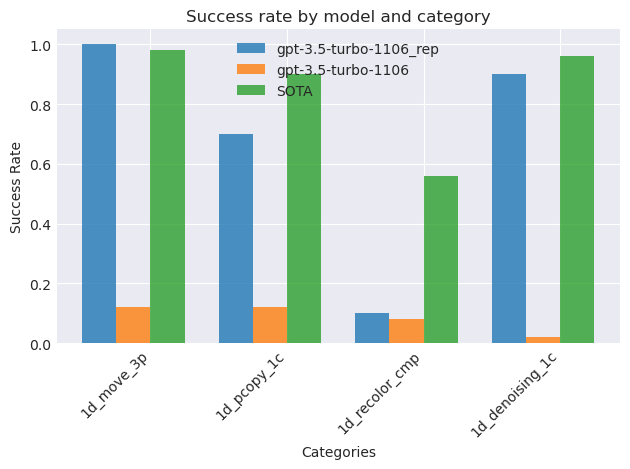

In [23]:
# compare cot_o overall result vs. object representation of output correct  --- GPT 3
df_cot = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
df_cot_o = pd.read_csv("results/cot_objects/arc_1D/summary.csv")
df_cot_o_rep = df_cot_o.copy()
df_cot_o_rep["model"] = df_cot_o_rep["model"] + "_rep"
df_cot_o_rep = df_cot_o_rep.loc[:, ~df_cot_o_rep.columns.str.startswith('cat_success')]
rename_cols = {col: col.replace('object_info_object_representation_', '') 
               for col in df_cot_o_rep.columns if col.startswith('object_info_object_representation_cat_success_rate')}
df_cot_o_rep = df_cot_o_rep.rename(columns=rename_cols)
columns = list(set(df_cot.columns).intersection(set(df_cot_o_rep.columns)))
df = pd.concat([df_cot[columns], df_cot_o_rep[columns]])
filtered_df = df[df['model'].str.contains('gpt-3', case=False, na=False)]
plot_grouped_bar_chart(filtered_df, top_n_models=2, SOTA=SOTA["arc_1D"])


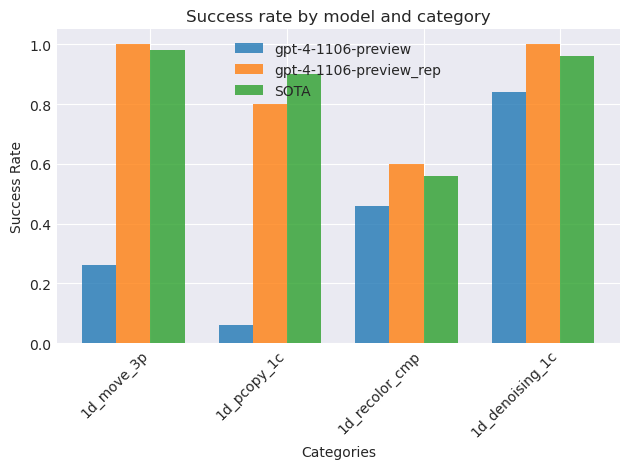

In [24]:
# compare cot_o overall result vs. object representation of output correct  --- GPT 4
df_cot = pd.read_csv("results/baseline_cot/arc_1D/summary.csv")
df_cot_o = pd.read_csv("results/cot_objects/arc_1D/summary.csv")
df_cot_o_rep = df_cot_o.copy()
df_cot_o_rep["model"] = df_cot_o_rep["model"] + "_rep"
df_cot_o_rep = df_cot_o_rep.loc[:, ~df_cot_o_rep.columns.str.startswith('cat_success')]
rename_cols = {col: col.replace('object_info_object_representation_', '') 
               for col in df_cot_o_rep.columns if col.startswith('object_info_object_representation_cat_success_rate')}
df_cot_o_rep = df_cot_o_rep.rename(columns=rename_cols)
columns = list(set(df_cot.columns).intersection(set(df_cot_o_rep.columns)))
df = pd.concat([df_cot[columns], df_cot_o_rep[columns]])
filtered_df = df[df['model'].str.contains('gpt-4', case=False, na=False)]
plot_grouped_bar_chart(filtered_df, top_n_models=2, SOTA=SOTA["arc_1D"])


##### Same Run: only object cmp across models 

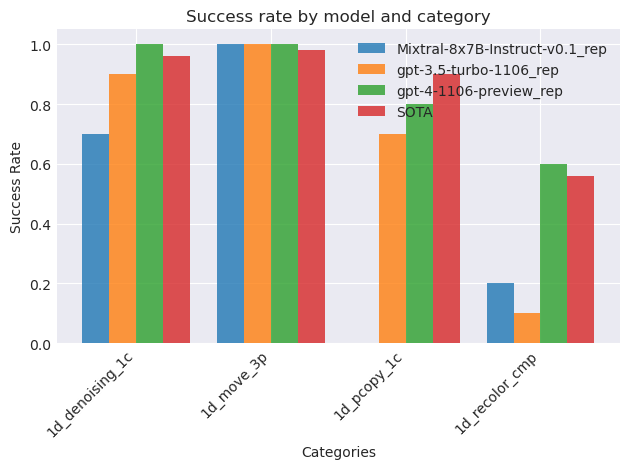

In [36]:
# compare cot_o overall result vs. object representation of output correct  --- GPT 3
df_cot_o = pd.read_csv("results/cot_objects/arc_1D/summary.csv")
df_cot_o_rep = df_cot_o.copy()
df_cot_o_rep["model"] = df_cot_o_rep["model"] + "_rep"
df_cot_o_rep = df_cot_o_rep.loc[:, ~df_cot_o_rep.columns.str.startswith('cat_success')]
rename_cols = {col: col.replace('object_info_object_representation_', '') 
               for col in df_cot_o_rep.columns if col.startswith('object_info_object_representation_cat_success_rate')}
df_cot_o_rep = df_cot_o_rep.rename(columns=rename_cols)
plot_grouped_bar_chart(df_cot_o_rep, top_n_models=3, SOTA=SOTA["arc_1D"])


### ARC H vs V

#### Plots

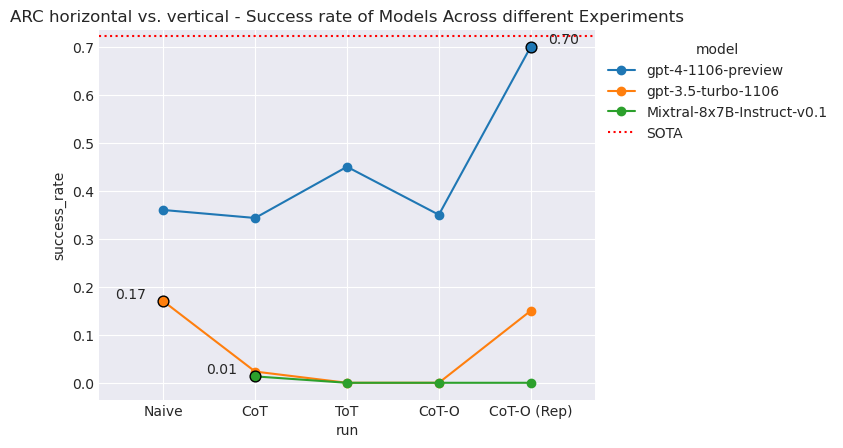

In [37]:
df_naive = pd.read_csv("results/baseline_naive/arc_h_v/summary.csv")
df_naive = df_naive[df_naive["new_representation"] == "0 - 9"]
df_naive["run"] = "Naive"
df_cot = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df_cot["run"] = "CoT"
df_tot = pd.read_csv("results/tot_normal/arc_h_v/summary.csv")
df_tot["run"] = "ToT"
df_cot_o = pd.read_csv("results/cot_objects/arc_h_v/summary.csv")
df_cot_o["run"] = "CoT-O"
df_cot_o_rep = pd.read_csv("results/cot_objects/arc_h_v/summary.csv")
df_cot_o_rep["success_rate"] = df_cot_o_rep["object_info_object_representation_success_rate"]
df_cot_o_rep["run"] = "CoT-O (Rep)"
df = pd.concat([df_naive, df_cot, df_tot,df_cot_o, df_cot_o_rep])
filtered_df = df[df['model'].str.contains('gpt-', case=False, na=False) | df['model'].str.contains('Mixtral-8x7B-Instruct', case=False, na=False)]
plot_model_performance_across_runs(filtered_df, "run", "success_rate", task="arc_h_v", SOTA=SOTA)

##### Same Run: grid output vs. object cmp

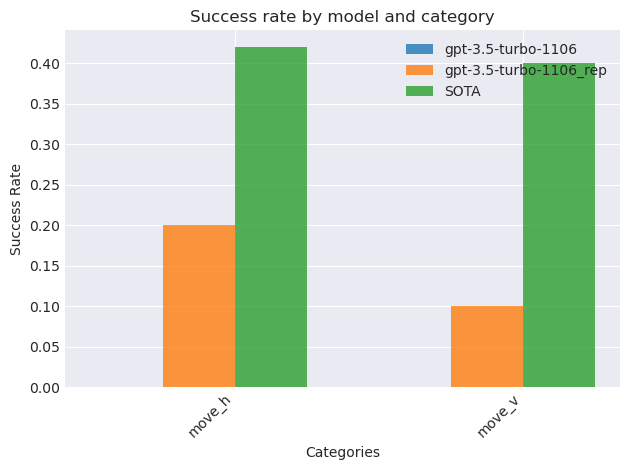

In [38]:
# compare cot_o overall result vs. object representation of output correct  --- GPT 3
df_cot_o = pd.read_csv("results/cot_objects/arc_h_v/summary.csv")
df_cot_o_rep = df_cot_o.copy()
df_cot_o_rep["model"] = df_cot_o_rep["model"] + "_rep"
df_cot_o_rep = df_cot_o_rep.loc[:, ~df_cot_o_rep.columns.str.startswith('cat_success')]
rename_cols = {col: col.replace('object_info_object_representation_', '') 
               for col in df_cot_o_rep.columns if col.startswith('object_info_object_representation_cat_success_rate')}
df_cot_o_rep = df_cot_o_rep.rename(columns=rename_cols)
df = pd.concat([df_cot_o, df_cot_o_rep])
filtered_df = df[df['model'].str.contains('gpt-3', case=False, na=False)]
plot_grouped_bar_chart(filtered_df, top_n_models=2, SOTA=SOTA["arc_h_v"])


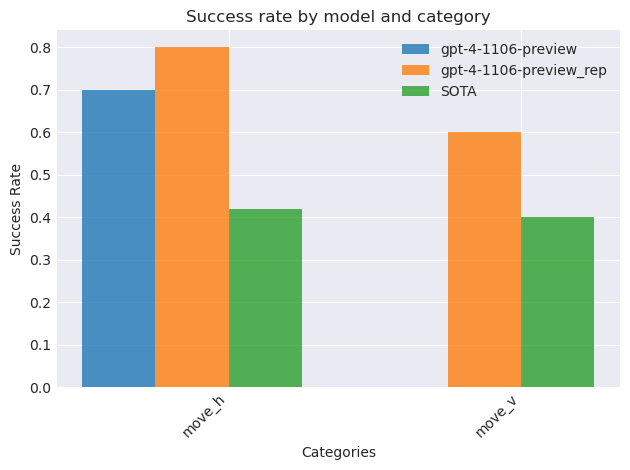

In [39]:
# compare cot_o overall result vs. object representation of output correct  --- GPT 4
df_cot_o = pd.read_csv("results/cot_objects/arc_h_v/summary.csv")
df_cot_o_rep = df_cot_o.copy()
df_cot_o_rep["model"] = df_cot_o_rep["model"] + "_rep"
df_cot_o_rep = df_cot_o_rep.loc[:, ~df_cot_o_rep.columns.str.startswith('cat_success')]
rename_cols = {col: col.replace('object_info_object_representation_', '') 
               for col in df_cot_o_rep.columns if col.startswith('object_info_object_representation_cat_success_rate')}
df_cot_o_rep = df_cot_o_rep.rename(columns=rename_cols)
df = pd.concat([df_cot_o, df_cot_o_rep])
filtered_df = df[df['model'].str.contains('gpt-4', case=False, na=False)]
plot_grouped_bar_chart(filtered_df, top_n_models=2, SOTA=SOTA["arc_h_v"])

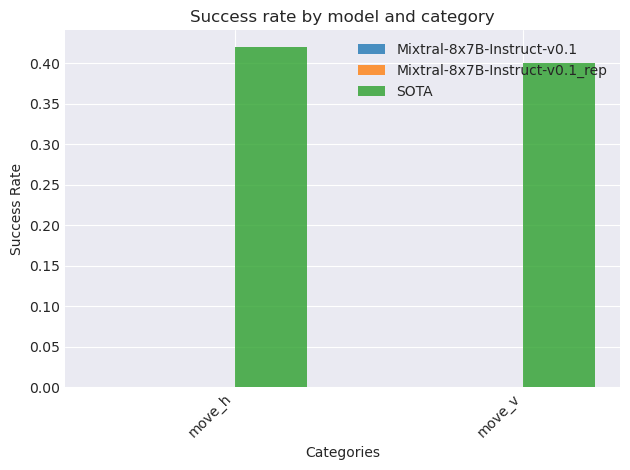

In [40]:
# compare cot_o overall result vs. object representation of output correct  --- Mixtral
df_cot_o = pd.read_csv("results/cot_objects/arc_h_v/summary.csv")
df_cot_o_rep = df_cot_o.copy()
df_cot_o_rep["model"] = df_cot_o_rep["model"] + "_rep"
df_cot_o_rep = df_cot_o_rep.loc[:, ~df_cot_o_rep.columns.str.startswith('cat_success')]
rename_cols = {col: col.replace('object_info_object_representation_', '') 
               for col in df_cot_o_rep.columns if col.startswith('object_info_object_representation_cat_success_rate')}
df_cot_o_rep = df_cot_o_rep.rename(columns=rename_cols)
df = pd.concat([df_cot_o, df_cot_o_rep])
filtered_df = df[df['model'].str.contains('Mixtral-8x7B-Instruct', case=False, na=False)]
plot_grouped_bar_chart(filtered_df, top_n_models=2, SOTA=SOTA["arc_h_v"])


##### Different Runs: normal CoT vs. object cmp 

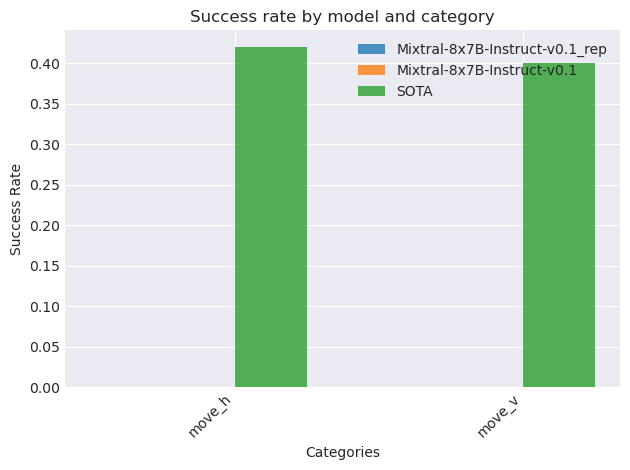

In [41]:
# compare cot_o overall result vs. object representation of output correct  --- Mixtral
df_cot = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df_cot_o = pd.read_csv("results/cot_objects/arc_h_v/summary.csv")
df_cot_o_rep = df_cot_o.copy()
df_cot_o_rep["model"] = df_cot_o_rep["model"] + "_rep"
df_cot_o_rep = df_cot_o_rep.loc[:, ~df_cot_o_rep.columns.str.startswith('cat_success')]
rename_cols = {col: col.replace('object_info_object_representation_', '') 
               for col in df_cot_o_rep.columns if col.startswith('object_info_object_representation_cat_success_rate')}
df_cot_o_rep = df_cot_o_rep.rename(columns=rename_cols)
columns = list(set(df_cot.columns).intersection(set(df_cot_o_rep.columns)))
df = pd.concat([df_cot[columns], df_cot_o_rep[columns]])
filtered_df = df[df['model'].str.contains('Mixtral-8x7B-Instruct', case=False, na=False)]
plot_grouped_bar_chart(filtered_df, top_n_models=2, SOTA=SOTA["arc_h_v"])


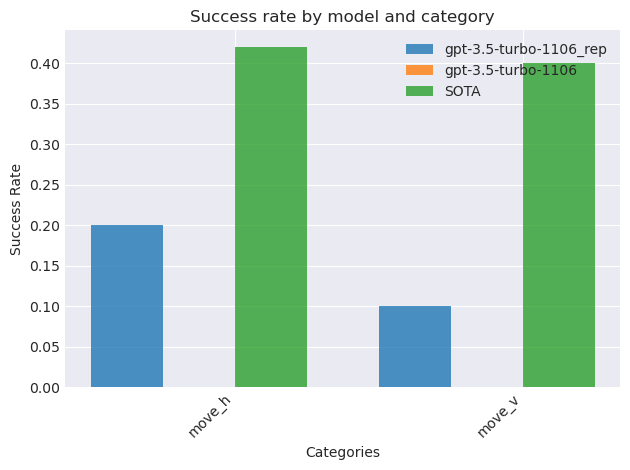

In [42]:
# compare cot_o overall result vs. object representation of output correct  --- GPT 3
df_cot = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df_cot_o = pd.read_csv("results/cot_objects/arc_h_v/summary.csv")
df_cot_o_rep = df_cot_o.copy()
df_cot_o_rep["model"] = df_cot_o_rep["model"] + "_rep"
df_cot_o_rep = df_cot_o_rep.loc[:, ~df_cot_o_rep.columns.str.startswith('cat_success')]
rename_cols = {col: col.replace('object_info_object_representation_', '') 
               for col in df_cot_o_rep.columns if col.startswith('object_info_object_representation_cat_success_rate')}
df_cot_o_rep = df_cot_o_rep.rename(columns=rename_cols)
columns = list(set(df_cot.columns).intersection(set(df_cot_o_rep.columns)))
df = pd.concat([df_cot[columns], df_cot_o_rep[columns]])
filtered_df = df[df['model'].str.contains('gpt-3', case=False, na=False)]
plot_grouped_bar_chart(filtered_df, top_n_models=2, SOTA=SOTA["arc_h_v"])


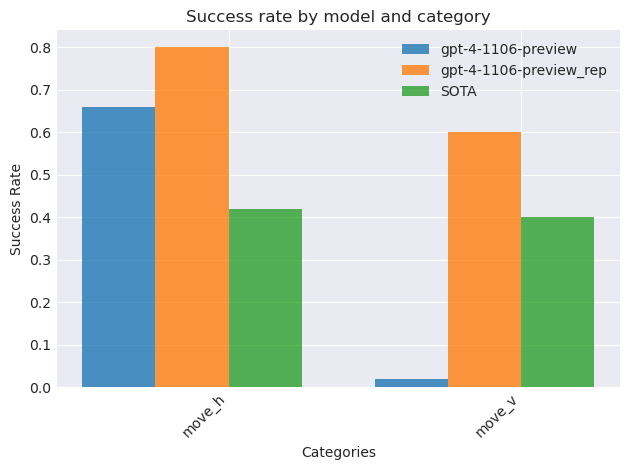

In [43]:
# compare cot_o overall result vs. object representation of output correct  --- GPT 4
df_cot = pd.read_csv("results/baseline_cot/arc_h_v/summary.csv")
df_cot_o = pd.read_csv("results/cot_objects/arc_h_v/summary.csv")
df_cot_o_rep = df_cot_o.copy()
df_cot_o_rep["model"] = df_cot_o_rep["model"] + "_rep"
df_cot_o_rep = df_cot_o_rep.loc[:, ~df_cot_o_rep.columns.str.startswith('cat_success')]
rename_cols = {col: col.replace('object_info_object_representation_', '') 
               for col in df_cot_o_rep.columns if col.startswith('object_info_object_representation_cat_success_rate')}
df_cot_o_rep = df_cot_o_rep.rename(columns=rename_cols)
columns = list(set(df_cot.columns).intersection(set(df_cot_o_rep.columns)))
df = pd.concat([df_cot[columns], df_cot_o_rep[columns]])
filtered_df = df[df['model'].str.contains('gpt-4', case=False, na=False)]
plot_grouped_bar_chart(filtered_df, top_n_models=2, SOTA=SOTA["arc_h_v"])


##### Same Run: only object cmp across models 

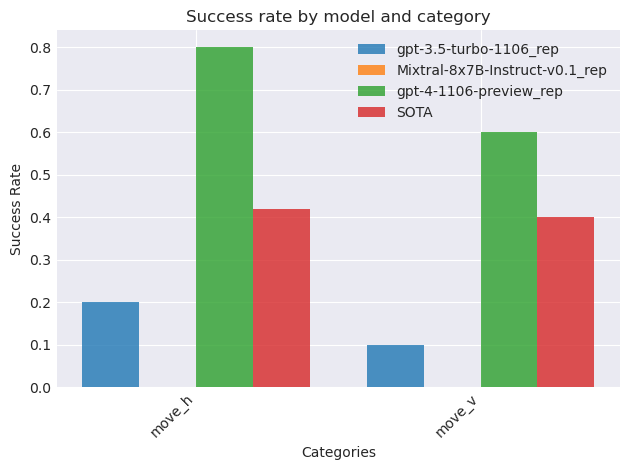

In [44]:
# compare cot_o overall result vs. object representation of output correct  --- GPT 3
df_cot_o = pd.read_csv("results/cot_objects/arc_h_v/summary.csv")
df_cot_o_rep = df_cot_o.copy()
df_cot_o_rep["model"] = df_cot_o_rep["model"] + "_rep"
df_cot_o_rep = df_cot_o_rep.loc[:, ~df_cot_o_rep.columns.str.startswith('cat_success')]
rename_cols = {col: col.replace('object_info_object_representation_', '') 
               for col in df_cot_o_rep.columns if col.startswith('object_info_object_representation_cat_success_rate')}
df_cot_o_rep = df_cot_o_rep.rename(columns=rename_cols)
plot_grouped_bar_chart(df_cot_o_rep, top_n_models=3, SOTA=SOTA["arc_h_v"])
